# Entendendo o negócio

- A motivação

  Qual o contexto
  
  
- A causa raiz do problema

  Porque fazer uma previsao de vendas?
  
  
- Quem é o dono do problema

  Quem sera o stakeholder
  
  
- Formato de solução

  Granularidade, Tipo de Problema, potenciais metodos, formato de entrega
  

A motivação:
    - O CFO requisitou essa solução durante uma reuniáo de resultados mensais
A causa raiz do problema:
    - Investimento em reforma das lojas
Quem é o stakeholder:
    - O CFO
O formato da solução:
    - Vendas diarias em R$ nas próximas 6 semanas

# Update do processo

1 - Questão de negócio - ok

2 - Entendimento do negócio - ok

3 - Coleta de dados - ok

4 - limpeza dos dados - ok

# O quão desafiador é o problema?

 - Para isso é entender a quantidade de dados para saber quais recursos corretos trabalhar(Servidores, Clusters, Spark. Hadoop)
 - Saber os tipos de variaveis (numericas, categóricas, temporal)
 - Saber a quantidade de dados faltantes e suas razões(NAs ou vazios, feitos por sistemas com algum problema ou inputs manuais) para poder tomar as decisões entre fazer o projeto ou preencher os dados vazios
 - Fazer o resumo geral dos dados (estatistica descritivas) para ter noção sobre seus dados

# Descrição dos dados com Python

# 0.0 Imports



In [2]:
import pandas as pd
import inflection
import math
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import Image
import datetime
from tabulate import tabulate
from scipy import stats as ss
import pickle

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.linear_model  import LinearRegression, Lasso
import xgboost as xgb
import random
import warnings 
warnings.filterwarnings ('ignore')


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [1]:
pip install RISE

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 4.1 MB/s eta 0:00:00m eta 0:00:010:01:01
Note: you may need to restart the kernel to use updated packages.


## 0.1 Helper Functions

In [3]:
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation 
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 ) 
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )


def mean_percentage_error( y, yhat ):  
    return np.mean( ( y - yhat ) / y )
     
    
def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y - yhat ) / y ) )

    
def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name': model_name, 
                           'MAE': mae, 
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] )

def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )



def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [4]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading data

In [9]:
df_sales_raw = pd.read_csv('~/COMUNIDADE_DS/DS_EM_PRODUCAO/Data/train.csv', low_memory= False)
df_store_raw = pd.read_csv('~/COMUNIDADE_DS/DS_EM_PRODUCAO/Data/store.csv', low_memory= False)

# merge
df_raw = pd.merge(df_sales_raw,df_store_raw, how = 'left', on = 'Store')


# 1.0 Descrição dos dados

In [10]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [11]:
df_raw.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [12]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

#estilo Snake_Case
snakecase = lambda x: inflection.underscore(x)

# o map faz uma mapeamento da snakecase em todas as palabras da lista cols_old e retorna a função em uma lista nova lista 
cols_new = list(map(snakecase, cols_old))

# renomeando as colunas
df1.columns = cols_new

In [13]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 Data Dimensions

In [14]:
# shape pega linha e coluna
print ('Number of rows: {}' .format(df1.shape[0]))
print ('Number of cols: {}' .format(df1.shape[1]))

Number of rows: 1017209
Number of cols: 18


## 1.3 Data Types

In [15]:
# convertendo os object em datetime
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [16]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA  (preencher os NAs)

In [17]:
df1.sample()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
608868,864,4,2014-01-02,3764,498,1,0,0,1,a,a,1020.0,10.0,2012.0,1,45.0,2009.0,"Feb,May,Aug,Nov"


In [18]:
#competition_distance        
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

#competition_open_since_year 
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

#promo2_since_week           
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

#promo2_since_year           
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

#promo_interval              
month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True )

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )


In [19]:
df1.sample(5).T

,533759,787265,478966,408359,31863
store,460,861,302,1044,644
day_of_week,1,5,1,2,5
date,2014-03-10 00:00:00,2013-07-26 00:00:00,2014-04-28 00:00:00,2014-07-01 00:00:00,2015-07-03 00:00:00
sales,2843,2492,4272,6163,9721
customers,307,407,349,843,1049
open,1,1,1,1,1
promo,0,0,1,1,1
state_holiday,0,0,0,0,0
school_holiday,0,1,0,0,0
store_type,a,c,d,c,c


In [20]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change Types

In [21]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [22]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [23]:
df1.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,0,0,0,0,0
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


## 1.7 Descriptive Statistical

In [24]:
#separar as caracteristicas das variaveis entre num e caract

num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )


### 1.7.1 Numerical Attributes

In [25]:
# Central Tendency - mean, meadina 
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

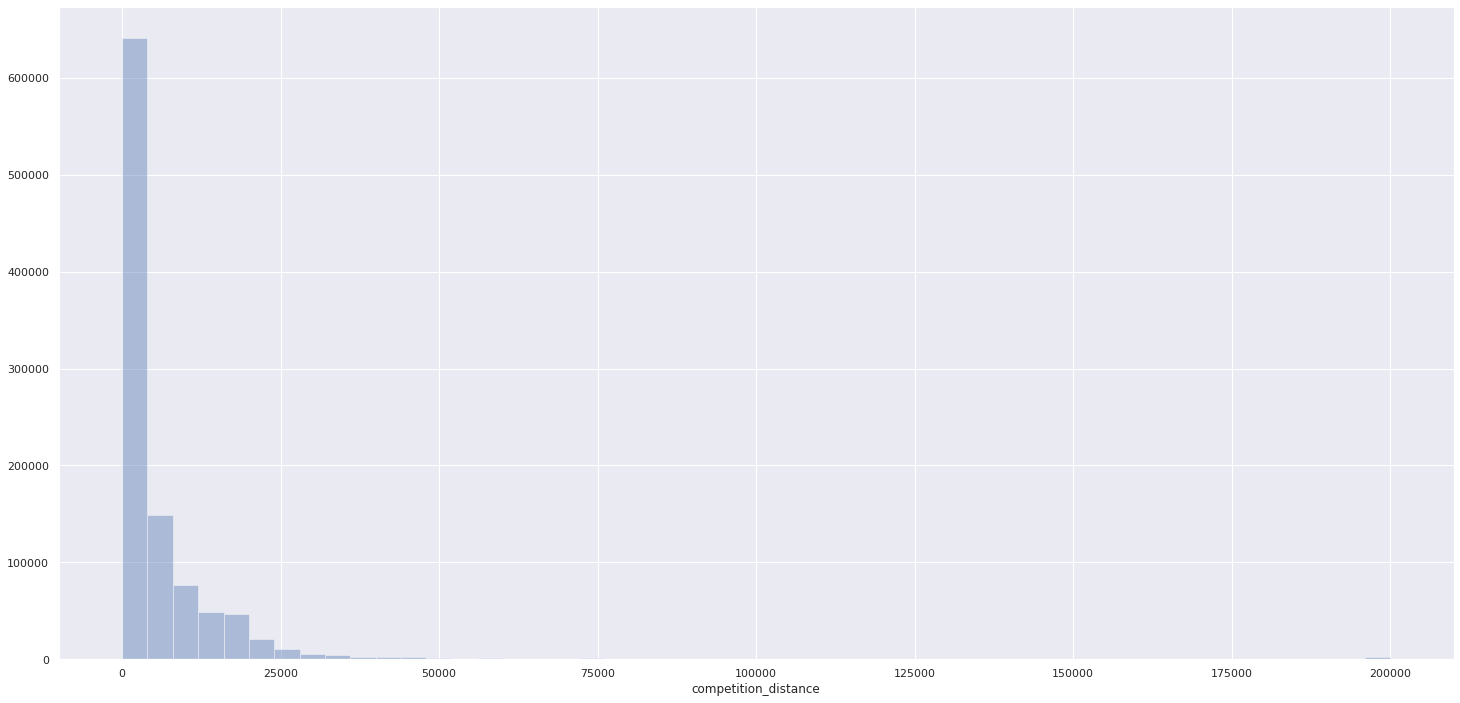

In [26]:
sns.distplot( df1['competition_distance'], kde=False )


### 1.7.2 Categorical Attributes

In [27]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

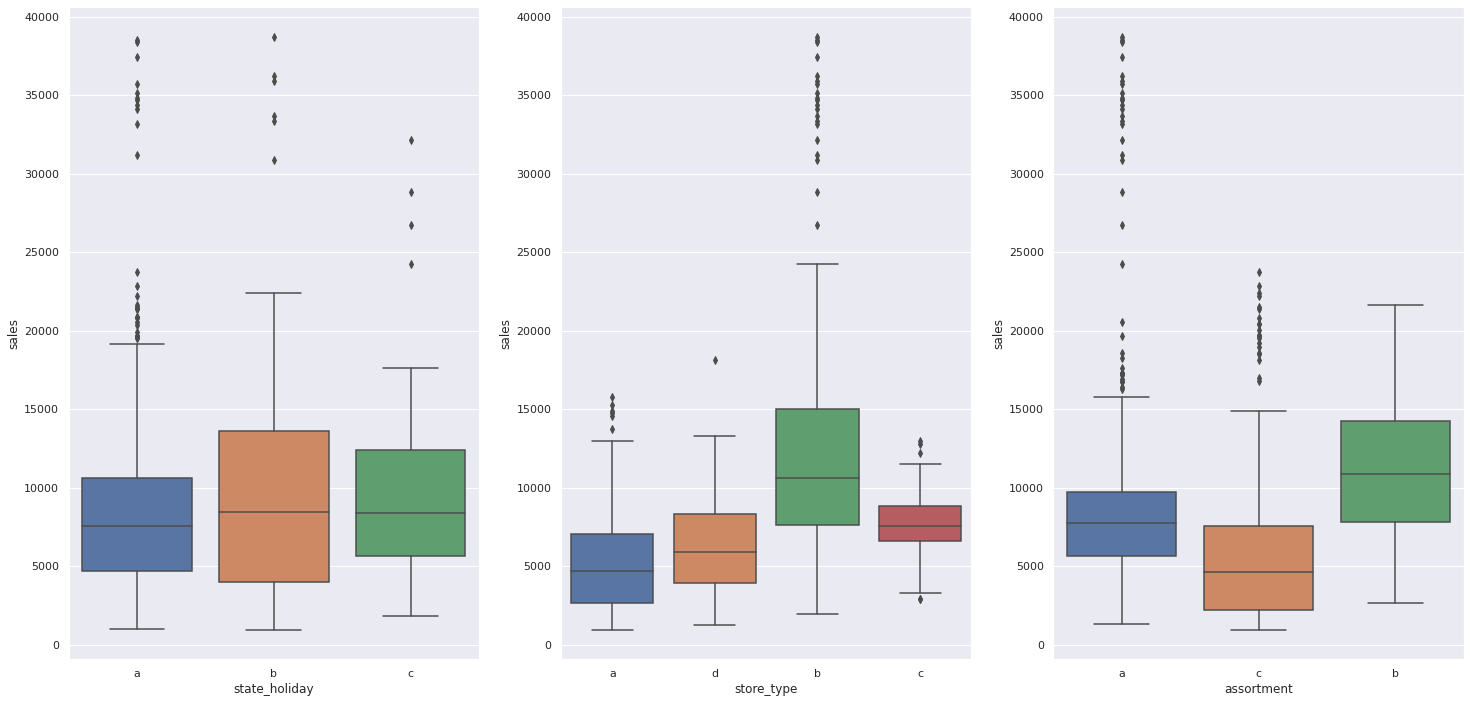

In [28]:
aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot( 1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data=aux )

plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=aux )

plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=aux )

# 2.0 Feature Engineering

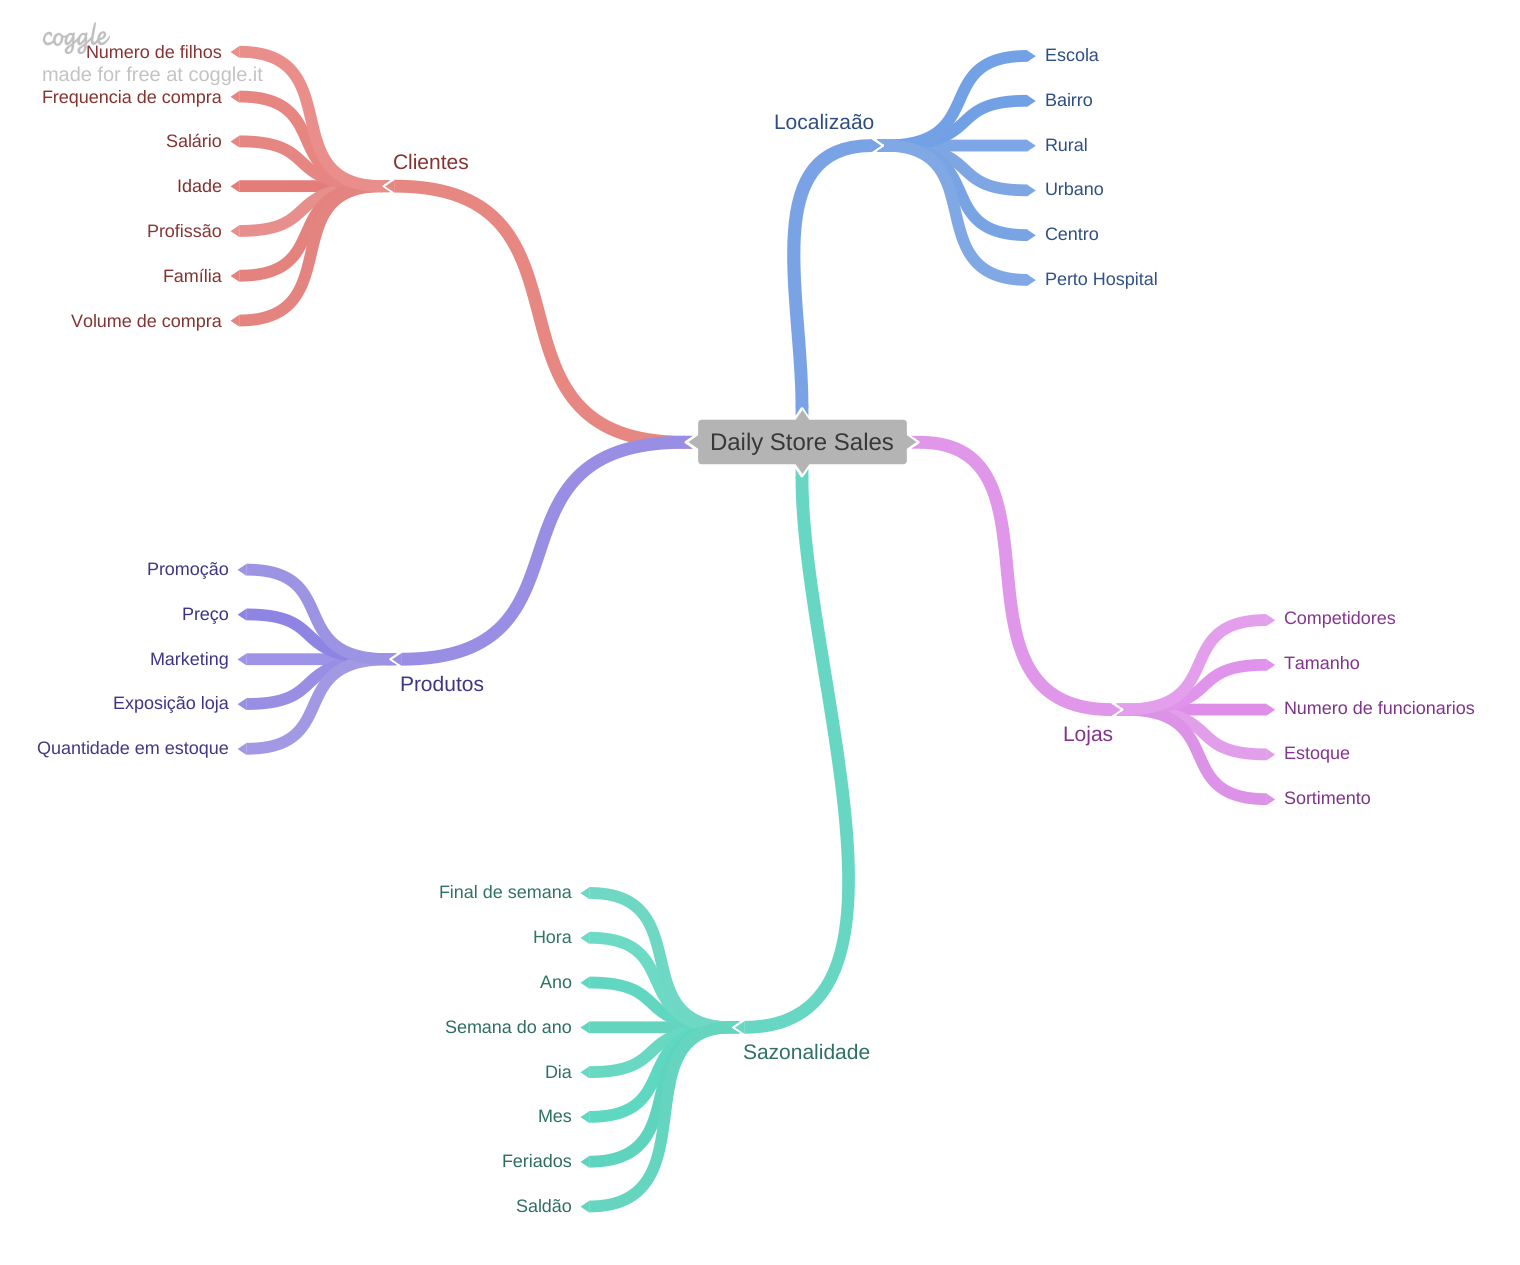

In [29]:
Image('../M03/Mind_map_hipotesis.png')

## 2.1 Criação das Hipoteses

### 2.1.1 Hipoteses Loja

**1.** Lojas com maior quadro de funcionarios deveriam vender mais.

**2.** Lojas com maior estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com maior sortimento deveriam vender mais.

**6.** Lojas com competidores à mais tempo deveriam vender mais



### 2.1.2 Hipoteses Produto

**1.** Lojas que investem mais em marketing deveriam vender mais.

**2.** Lojas que expõe mais o produto nas vitrines deveriam vender mais.

**3.** Lojas que tem preços menores nos produtos deveriam vender mais.

**4.** Lojas que tem preços menores por mais tempo nos produtos deveriam vender mais.

**5.** Lokas com promoçoes mais agressivas (descontos maiores), deveriam vender mais.

**6.** Lojas com promocoes ativas por mais tempo deveriam vender mais.

**7.** Lojas com mais dias de promocao deveriam vender mais.

**8.** Lojas com mais promocoes consecutivas deveriam vender mais.


### 2.1.3 Hipoteses Tempo

**1.** Lojas que tem mais feriados deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mes.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.


## 2.2 Lista final de Hipoteses

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

**8.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**9.** Lojas deveriam vender mais ao longo dos anos.

**10.** Lojas deveriam vender mais no segundo semestre do ano.

**11.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**12.** Lojas deveriam vender menos aos finais de semana.

**13.** Lojas deveriam vender menos durante os feriados escolares.


## 2.3 Feature Engineering

In [30]:
# copiando o df1 
df2 = df1.copy()

In [31]:
# deviração de variaveis

# year
df2['year'] = df2['date'].dt.year
# month
df2['month'] = df2['date'].dt.month
# day
df2['day'] = df2['date'].dt.day
# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear
# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')


# competition since - quanto tempo tenho a partir da data de agora desde quando a competicao começou
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

In [32]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 FILTRAGEM DE VARIÁVEIS


In [33]:
df3 = df2.copy()

## 3.1. Filtragem das Linhas

In [34]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

##  3.2. Selecao das Colunas

In [35]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1 )

In [36]:
df3.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


# 4.0 Analise exploratoria dos dados 

In [37]:
df4 = df3.copy()

## 4.1 Analise univariada

### 4.1.1 Response variavel

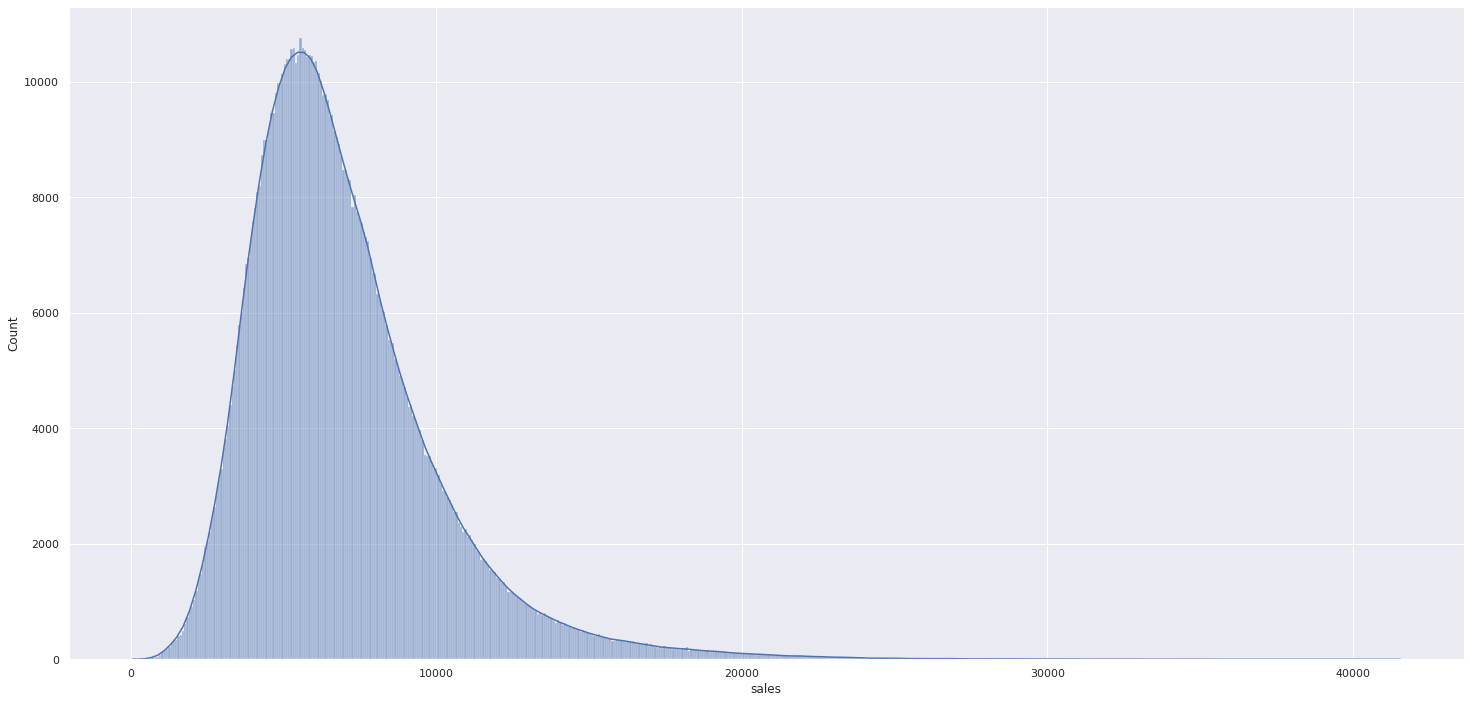

In [38]:
sns.histplot(df4['sales'], kde=True);

Tem um formato de uma distribuiçao normal mas está mais para a esquerda e isso é importante para os algoritimos de machine learning, pois eles tem condiçoes (dados independentes e normalmente distribuidos)

Existem maneiras de ajustar isso, como a escala logaritimica, exponencial e etc

Para o grafico acima, se quiser histograma é só colocar kdf = false

### 4.1.2 Numerical variavel

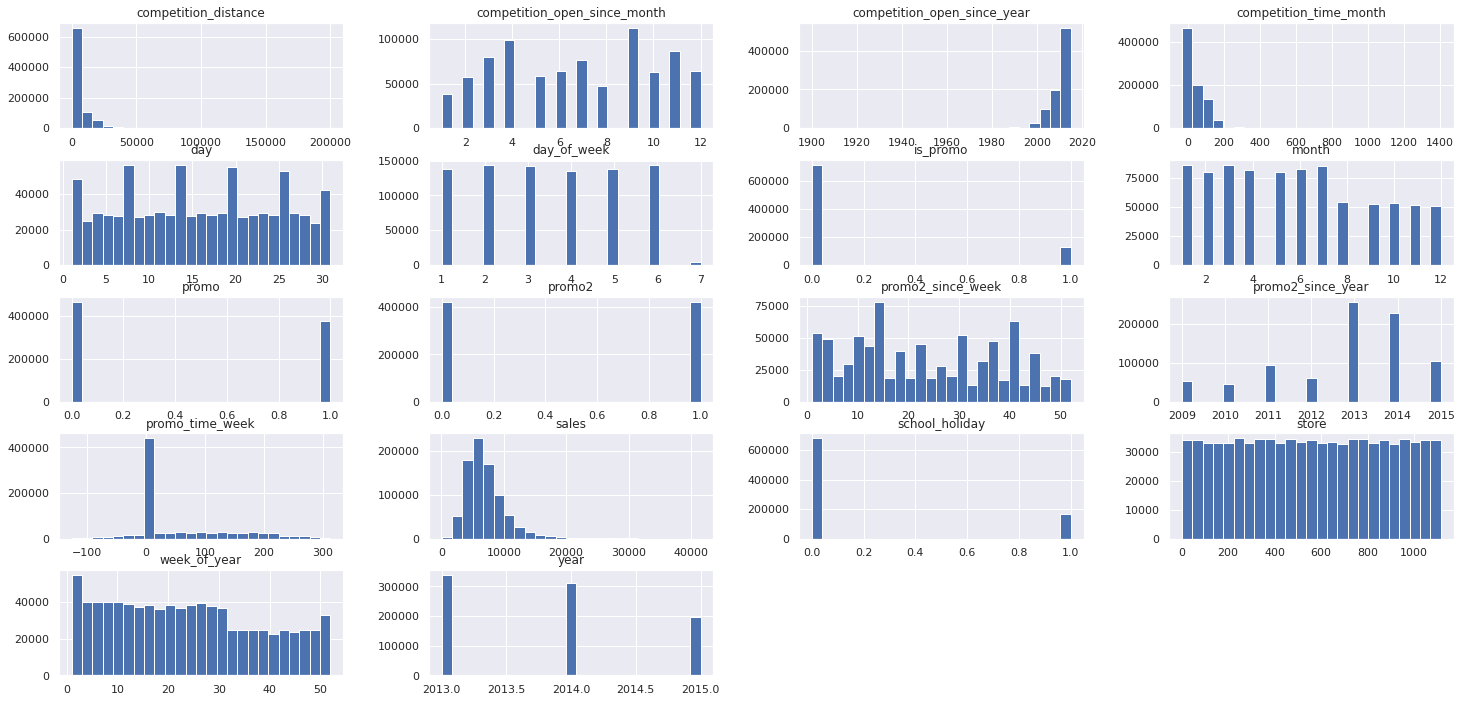

In [39]:
num_attributes = df4.select_dtypes(include=['int64', 'float64'])
num_attributes.hist(bins = 25); # bin é cada retangulo para demonstrar o conjunto de dados

### 4.1.3 Categorical variavel

In [40]:
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


In [41]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

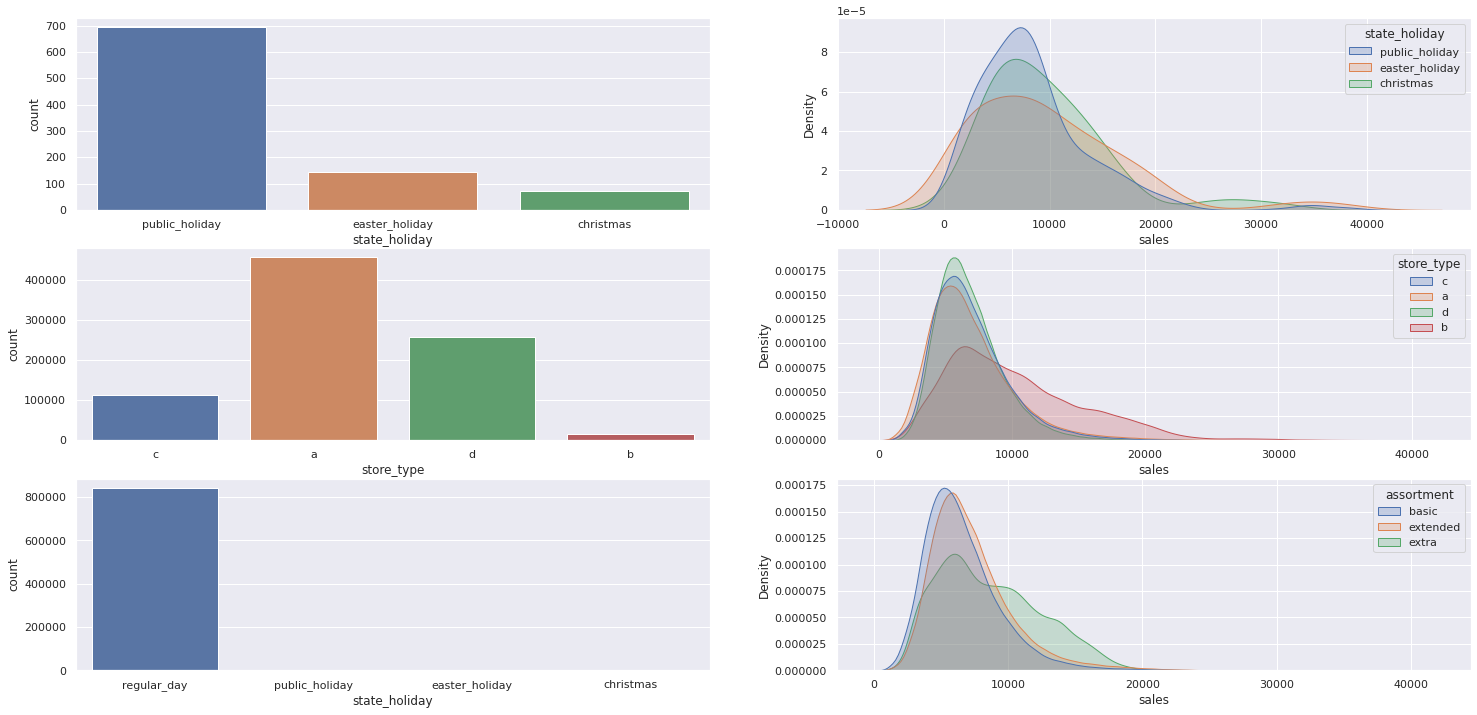

In [42]:
# state_holiday
plt.subplot(3,2,1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(x=a['state_holiday'])

#a = df4[df4['state_holiday'] != 'public_holiday']['sales']
plt.subplot(3,2,2)
sns.kdeplot(data=a, x='sales',hue='state_holiday', fill=True, common_norm=False)


# Store_type
plt.subplot(3,2,3)
sns.countplot(x=df4['store_type'])


plt.subplot(3,2,4)
sns.kdeplot(data=df4, x='sales', hue='store_type', fill=True, common_norm=False)

# assortment
plt.subplot(3,2,5)
sns.countplot(x=df4['state_holiday'])

plt.subplot(3,2,6)
sns.kdeplot(data=df4, x='sales', hue='assortment', fill=True, common_norm=False);

## 4.2 Analise bivariada


### **1.** Lojas com maior sortimentos deveriam vender mais.

In [43]:
df4.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


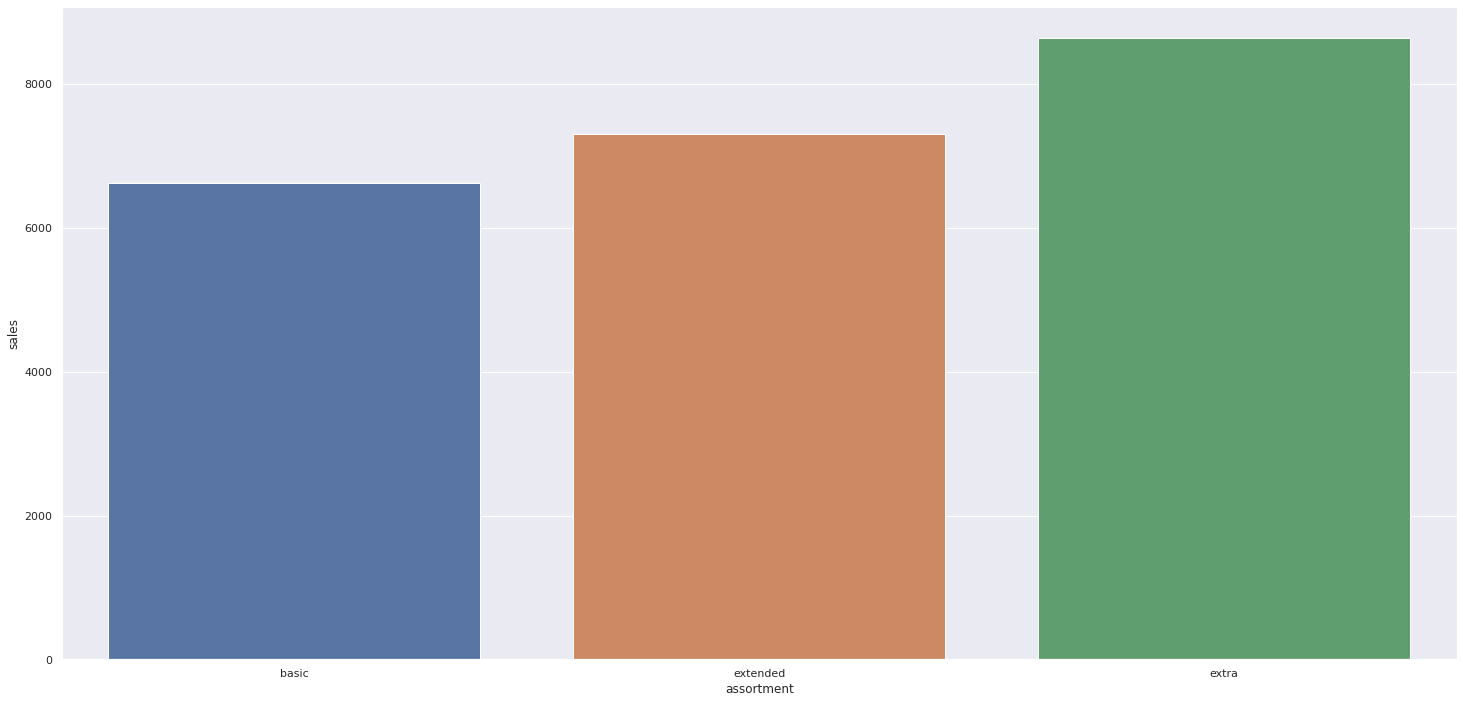

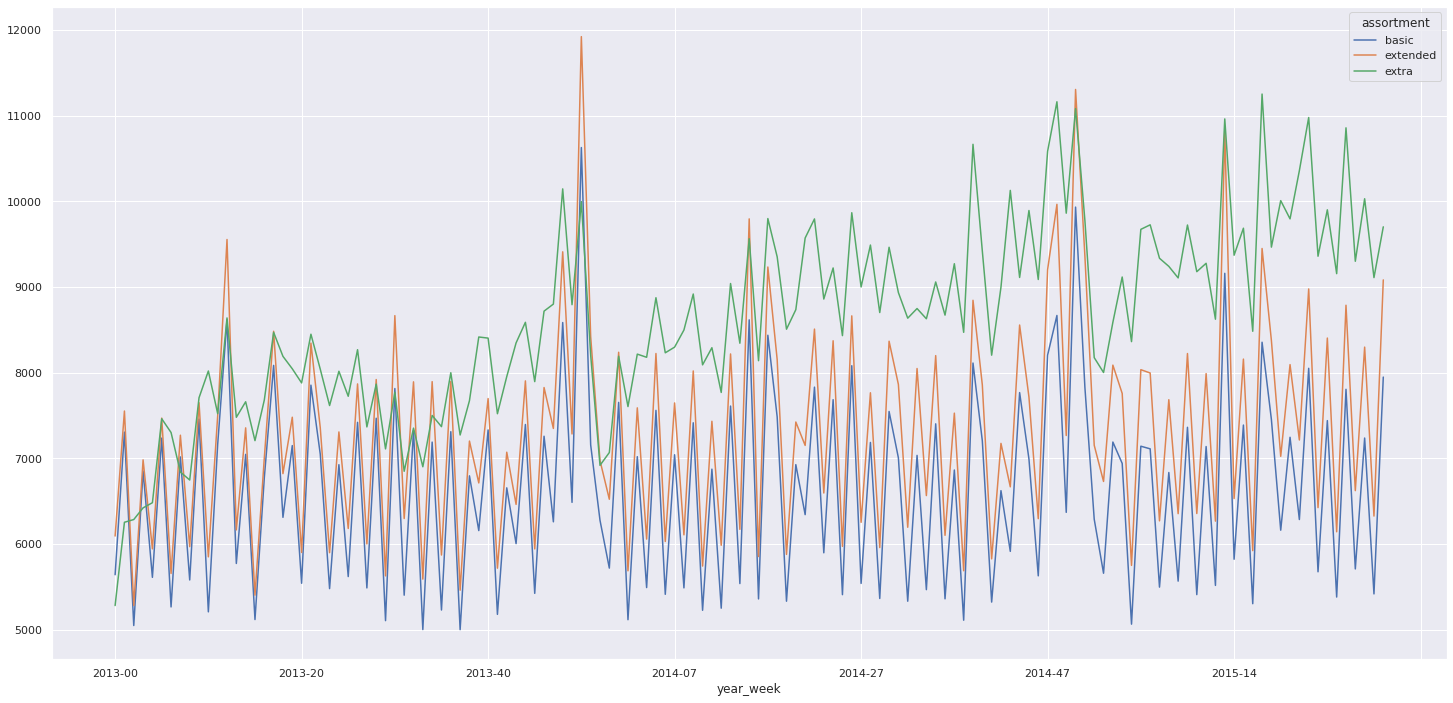

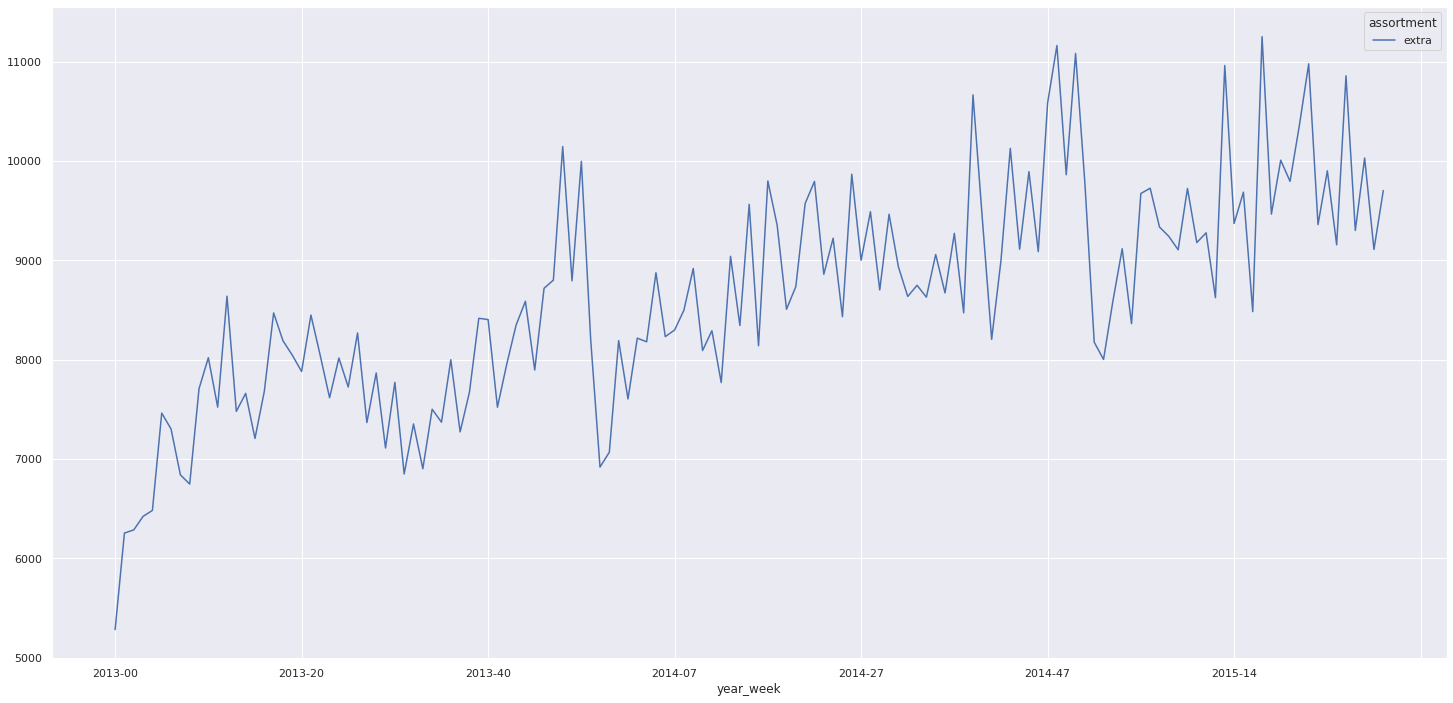

In [44]:
# interaçao de sortimento de mix de produtos em relaçao a variavel resposta(sales)
aux1 = df4[['assortment', 'sales']].groupby('assortment').mean().reset_index()
sns.barplot(x='assortment',y='sales',data=aux1);

aux2 = df4[['year_week','assortment', 'sales']].groupby(['year_week','assortment']).mean().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales').plot();

aux3 = aux2[aux2['assortment'] =='extra']
aux3 = aux3.pivot( index='year_week', columns='assortment', values='sales').plot();


 - Assumundo que o sortimento é o extra, a hipotese é falsa porque ela é a que menos vende

### **2.** Lojas com competidores mais próximos deveriam vender menos.


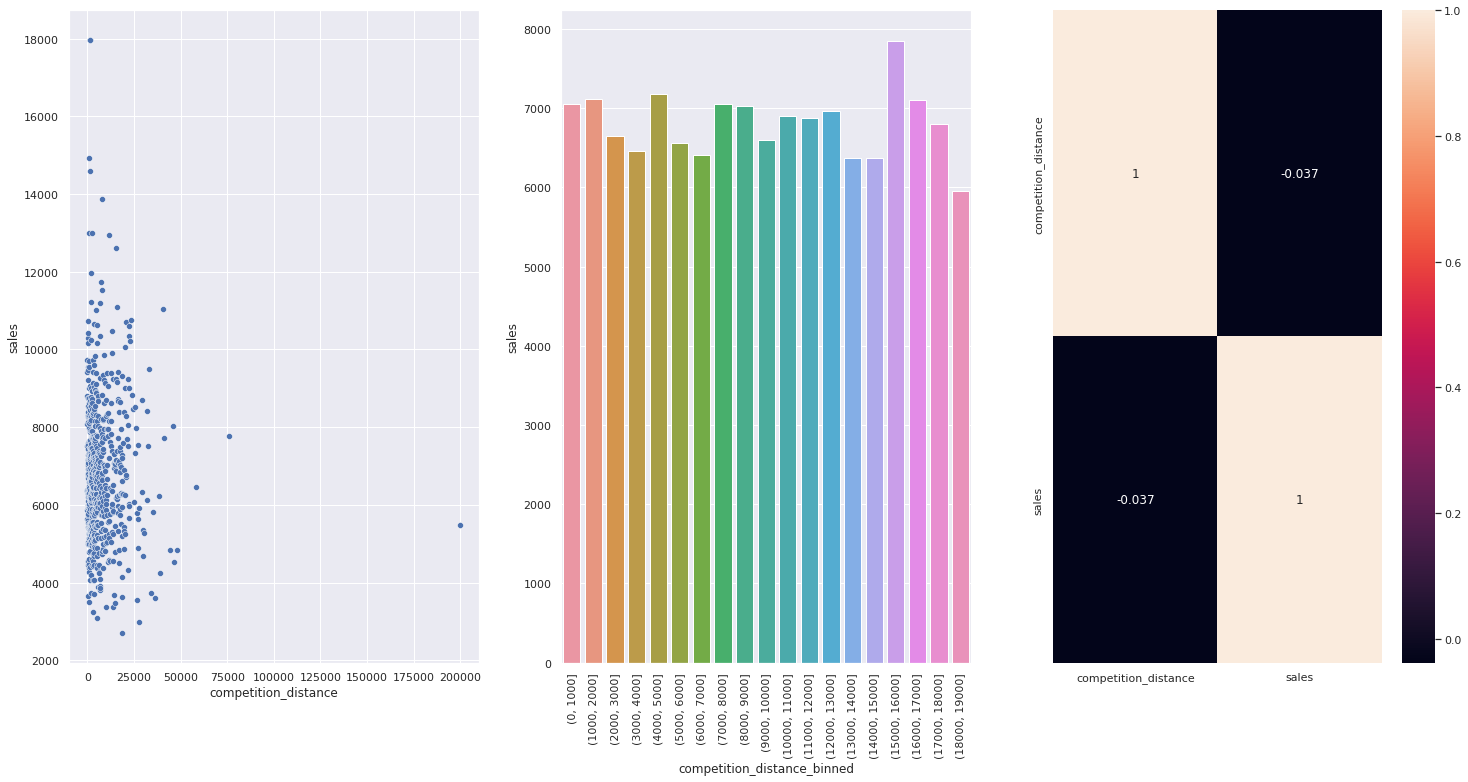

In [45]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').mean().reset_index()

plt.subplot(1,3,1)
sns.scatterplot(x = 'competition_distance', y= 'sales', data = aux1);

plt.subplot(1,3,2)
bins = list(np.arange(0,20000,1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins= bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').mean().reset_index()
sns.barplot(x = 'competition_distance_binned', y = 'sales', data= aux2);
plt.xticks(rotation = 90);

plt.subplot(1,3,3)
x = sns.heatmap(aux1.corr(method = 'pearson'), annot= True);
#bottom, top = x.get_ylim()
#x.get_ylim(bottom+0.56, top-0.5);

- a hipotese é falsa porque na verdade os competidores que estão vendendo mais são os mais próximos

### **3.** Lojas com competidores à mais tempo deveriam vendem mais.

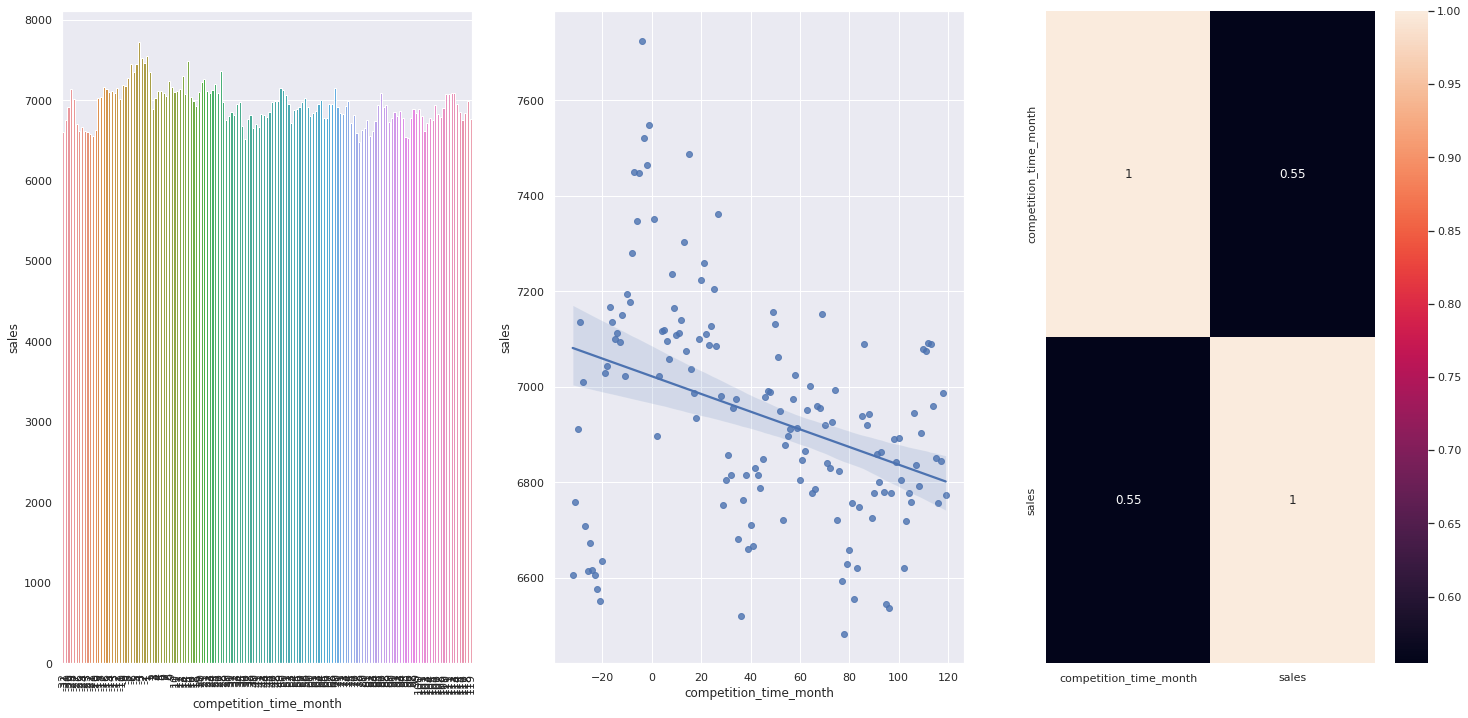

In [46]:
plt.subplot(1,3,1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').mean().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] !=0 ) ]
sns.barplot(x = 'competition_time_month', y= 'sales', data=aux2);
plt.xticks(rotation = 90)

plt.subplot(1,3,2)
sns.regplot(x = 'competition_time_month', y= 'sales', data=aux2);


plt.subplot(1,3,3)
x = sns.heatmap(aux1.corr(method= 'pearson'), annot = True);


### **4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

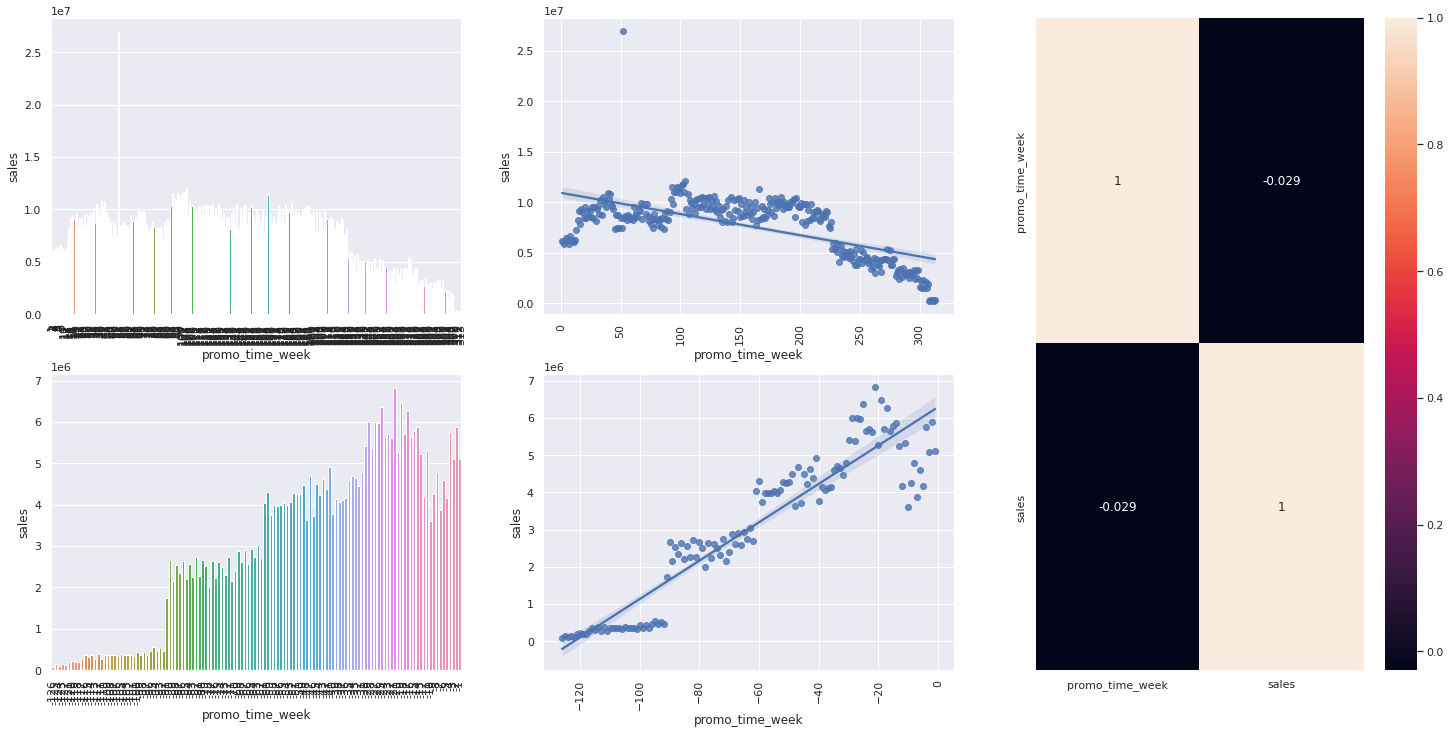

In [47]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec(2,3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week']> 0]
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux2);
plt.xticks (rotation = 90);

plt.subplot(grid[0,1])
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux2);
plt.xticks (rotation = 90);

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0]
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux3);
plt.xticks (rotation = 90);

plt.subplot(grid[1,1])
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux3);
plt.xticks (rotation = 90);

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);


Falsa, porque lojas com promoçoes ativas por um mais tempo vendem menos depois de um certo periodo de promoçao 

### **5.** <s> Lojas com mais dias de promoção deveriam vender mais.

sera validada no proximo ciclo do crisp

### **7.** Lojas com mais promoções consecutivas deveriam vender mais.

In [48]:
df4[['promo', 'promo2', 'sales']].groupby(['promo','promo2']).sum().reset_index()


,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


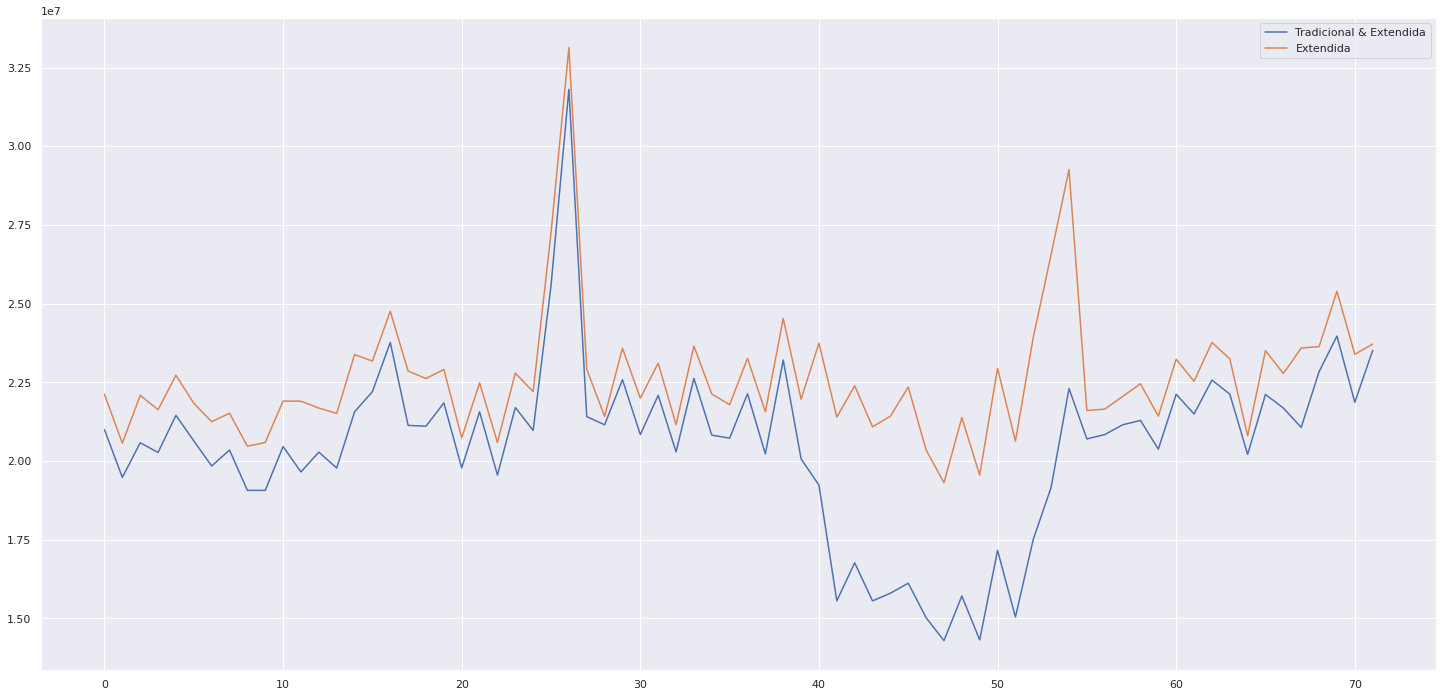

In [49]:
aux1 = df4[(df4[ 'promo'] == 1 ) & (df4[ 'promo2'] == 1 )][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4[ 'promo'] == 1 ) & (df4[ 'promo2'] == 0 )][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels = ['Tradicional & Extendida', 'Extendida'])

Falsa Lojas com mais promocoes consecutivas vendem menos

### **8.** Lojas abertas durante o feriado de Natal deveriam vender mais.


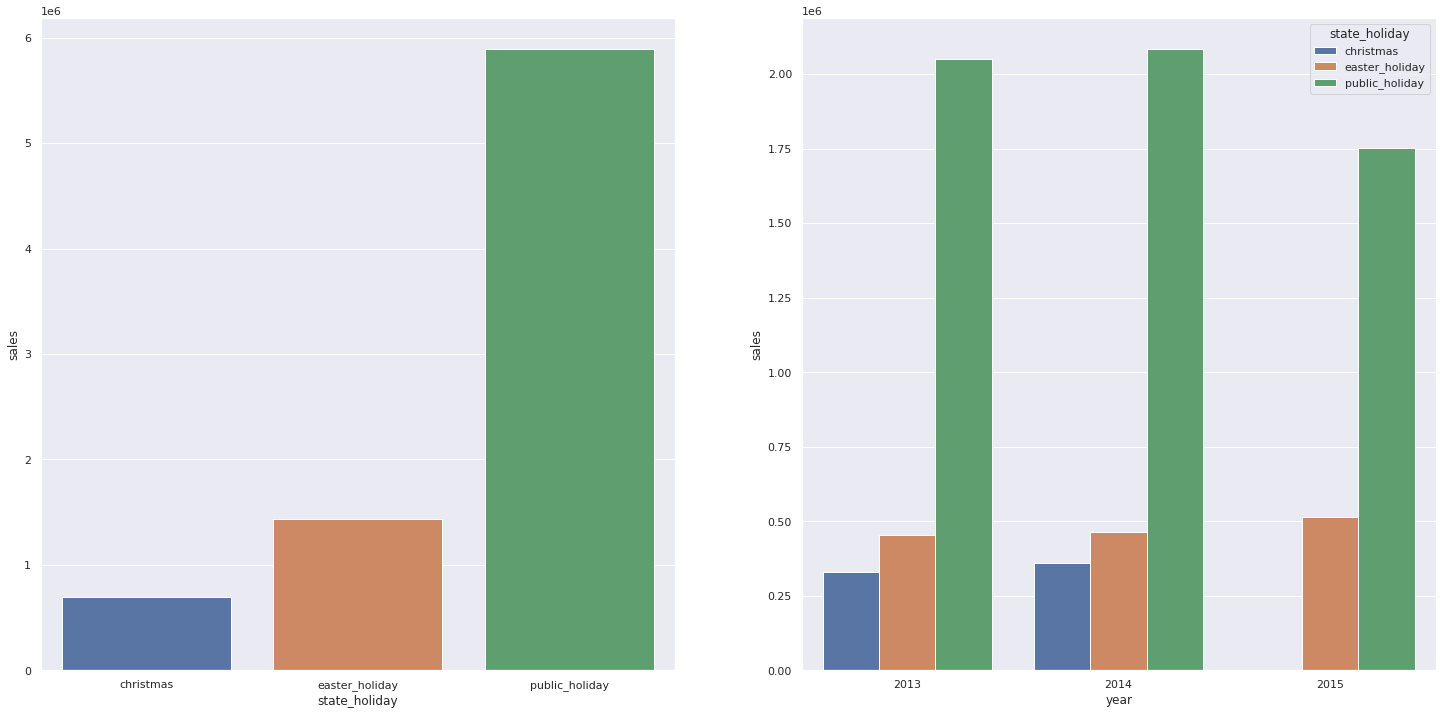

In [50]:
aux = df4[df4['state_holiday']!='regular_day']

plt.subplot (1,2,1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x = 'state_holiday', y= 'sales', data = aux1);

plt.subplot (1,2,2)
aux2 = aux[['year','state_holiday', 'sales' ]].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(x = 'year', y= 'sales', hue = 'state_holiday', data = aux2);

Falsa porque lojas abertas durante o feridado do natal vendem menos


### **9.** Lojas deveriam vender mais ao longo dos anos.


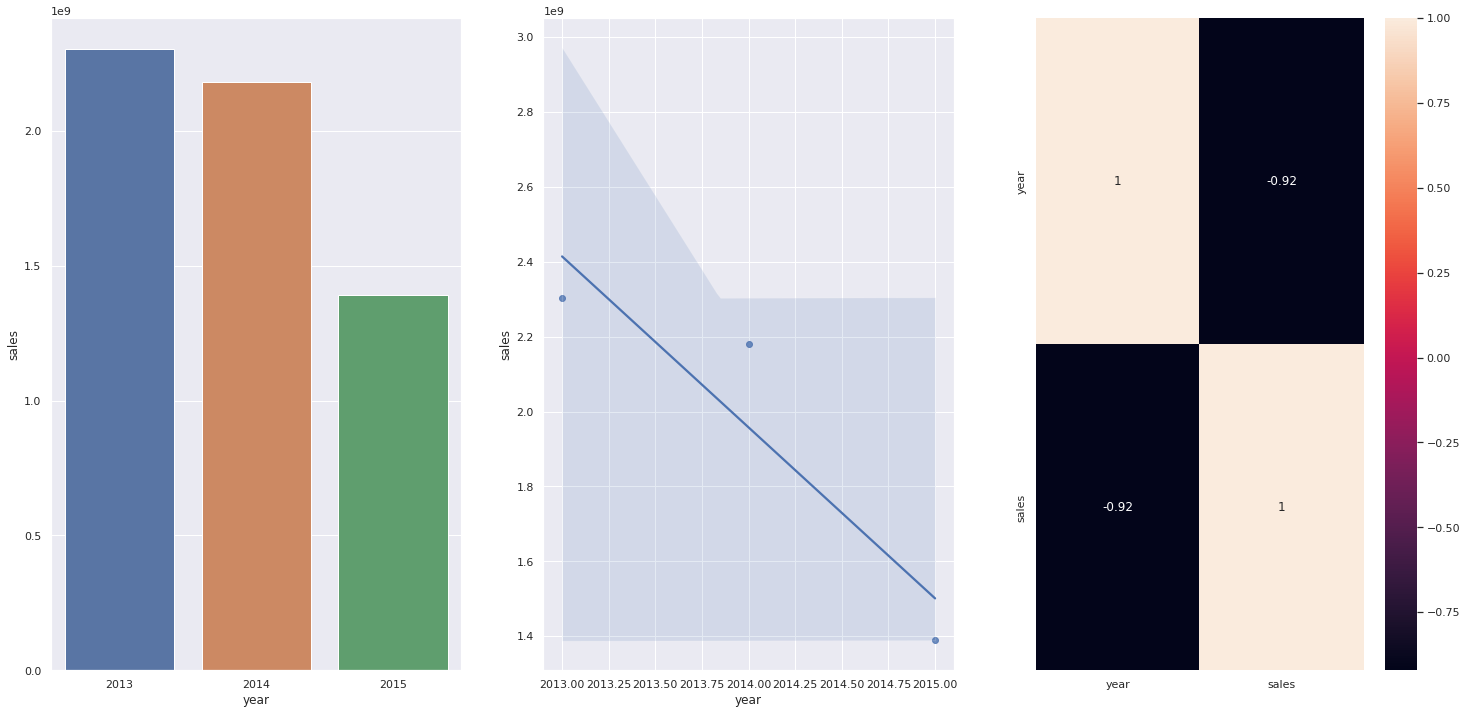

In [51]:

aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x = 'year', y= 'sales', data = aux1);

plt.subplot(1,3,2)
sns.regplot(x = 'year', y= 'sales', data = aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method= 'pearson'), annot= True);


Falsa porque elas estáo vendendo menos ao longo dos anos

### **10.** Lojas deveriam vender mais no segundo semestre do ano.


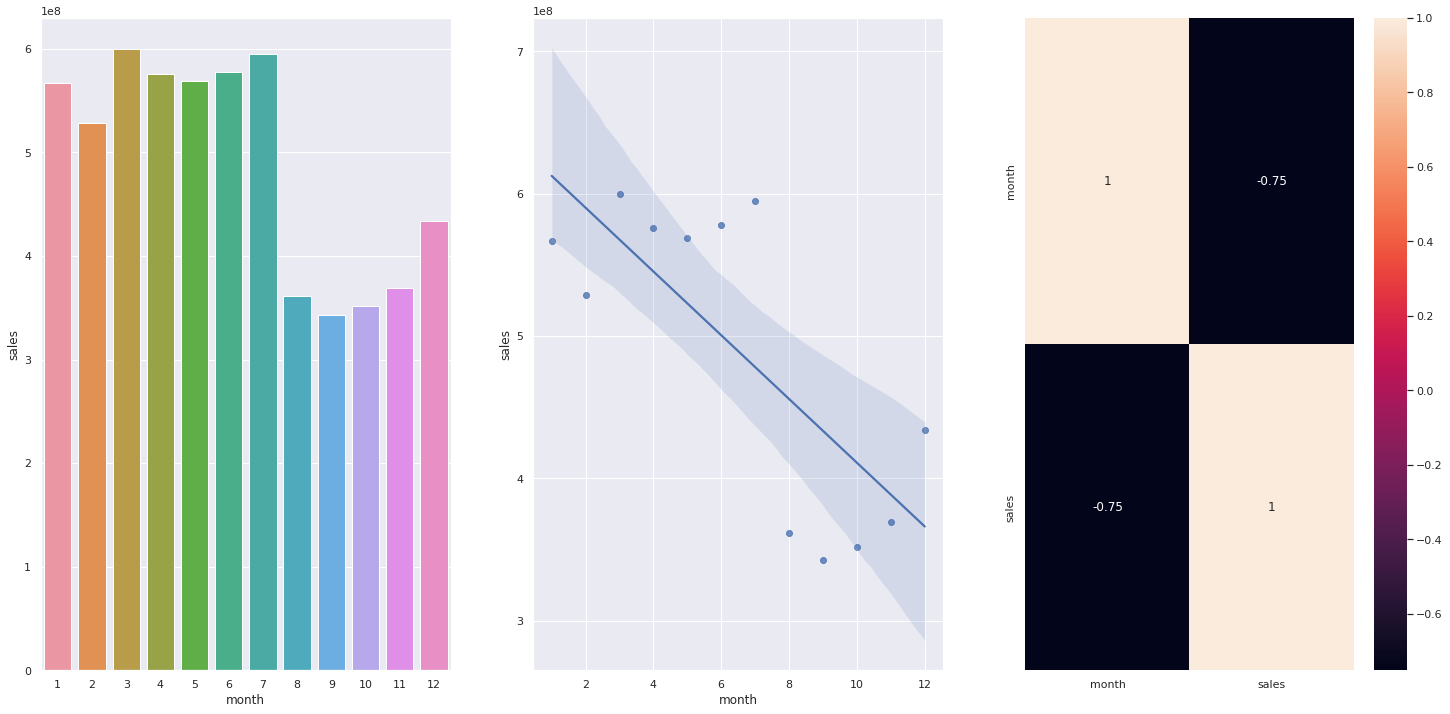

In [52]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x = 'month', y= 'sales', data = aux1);

plt.subplot(1,3,2)
sns.regplot(x = 'month', y= 'sales', data = aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method= 'pearson'), annot= True);


Falsa, na verdade é ao contrário

### **11.** Lojas deveriam vender mais depois do dia 10 de cada mês.


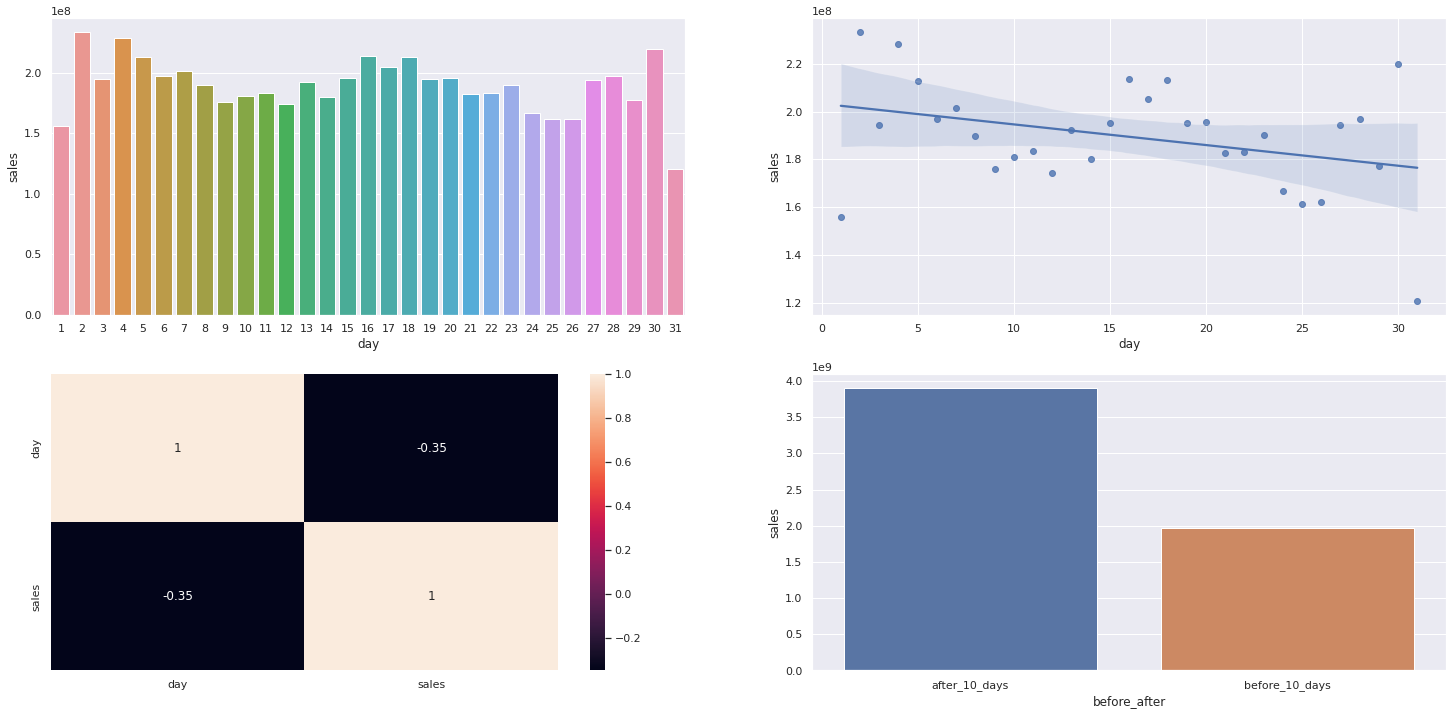

In [53]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x = 'day', y= 'sales', data = aux1);

plt.subplot(2,2,2)
sns.regplot(x = 'day', y= 'sales', data = aux1);

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method= 'pearson'), annot= True);

plt.subplot(2,2,4)
aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x<=10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()
sns.barplot(x = 'before_after', y= 'sales', data = aux2);

verdadeira, porque vendem mais depois do dia 10 de casa mes

### **12.** Lojas deveriam vender menos aos finais de semana.


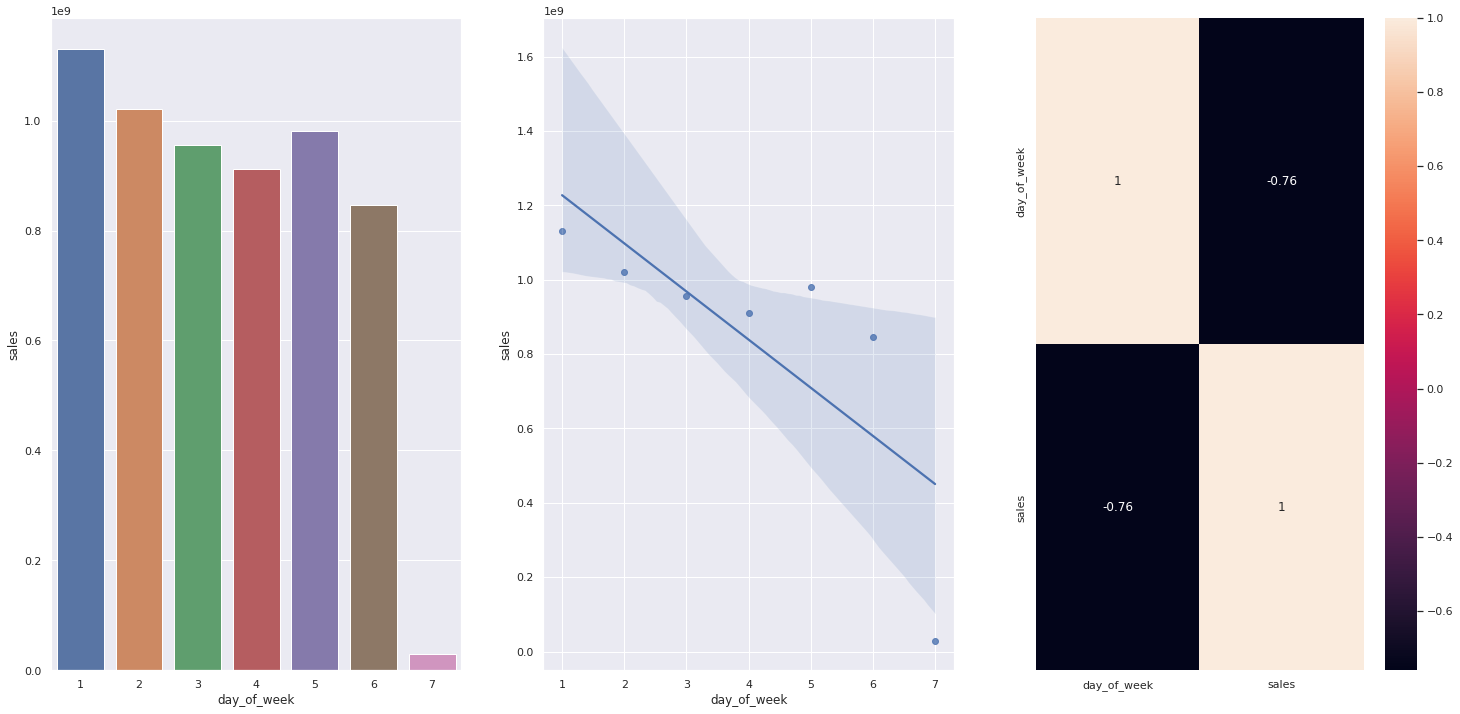

In [54]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x = 'day_of_week', y= 'sales', data = aux1);

plt.subplot(1,3,2)
sns.regplot(x = 'day_of_week', y= 'sales', data = aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method= 'pearson'), annot= True);

Verdadeira, porque realmente vendem menos

### **13.** Lojas deveriam vender menos durante os feriados escolares.

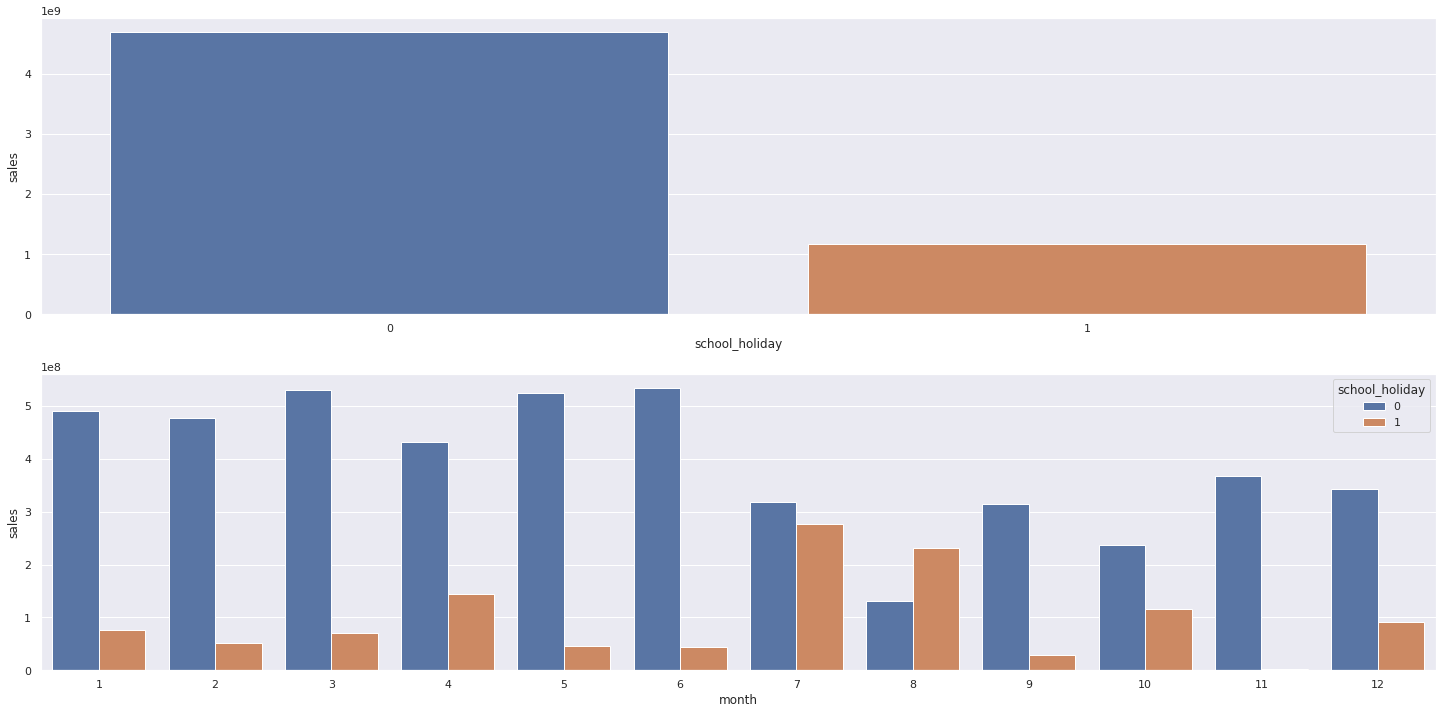

In [55]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(2,1,1)
sns.barplot(x = 'school_holiday', y= 'sales', data = aux1);

aux2 = df4[['month','school_holiday', 'sales']].groupby(['month','school_holiday']).sum().reset_index()

plt.subplot(2,1,2)
sns.barplot(x = 'month', y= 'sales',hue = 'school_holiday', data = aux2);


Verdade, realmente vendem menos

### 4.2.1 Resumo das hipoteses

In [56]:
tab = [['Hipoteses','Comclusão', 'Relevancia'],
['H1', 'FALSA', 'BAIXA'],
['H2', 'FALSA', 'MEDIA'],
['H3', 'FALSA', 'MEDIA'],
['H4', 'FALSA', 'BAIXA'],
['H5', '--', '--'],
['H7', 'FALSA', 'BAIXA'],
['H7', 'FALSA', 'MEDIA'],
['H8', 'FALSA', 'ALTA'],
['H9', 'FALSA', 'ALTA'],
['H10', 'VERDADEIRA', 'ALTA'],
['H11', 'VERDADEIRA', 'ALTA'],
['H12', 'VERDADEIRA', 'BAIXA']]

print(tabulate(tab,headers = 'firstrow'))

Hipoteses    Comclusão    Relevancia
-----------  -----------  ------------
H1           FALSA        BAIXA
H2           FALSA        MEDIA
H3           FALSA        MEDIA
H4           FALSA        BAIXA
H5           --           --
H7           FALSA        BAIXA
H7           FALSA        MEDIA
H8           FALSA        ALTA
H9           FALSA        ALTA
H10          VERDADEIRA   ALTA
H11          VERDADEIRA   ALTA
H12          VERDADEIRA   BAIXA


## 4.3 Analise Multivariada

### 4.3 Analise Multivariada - Numerical Attributes

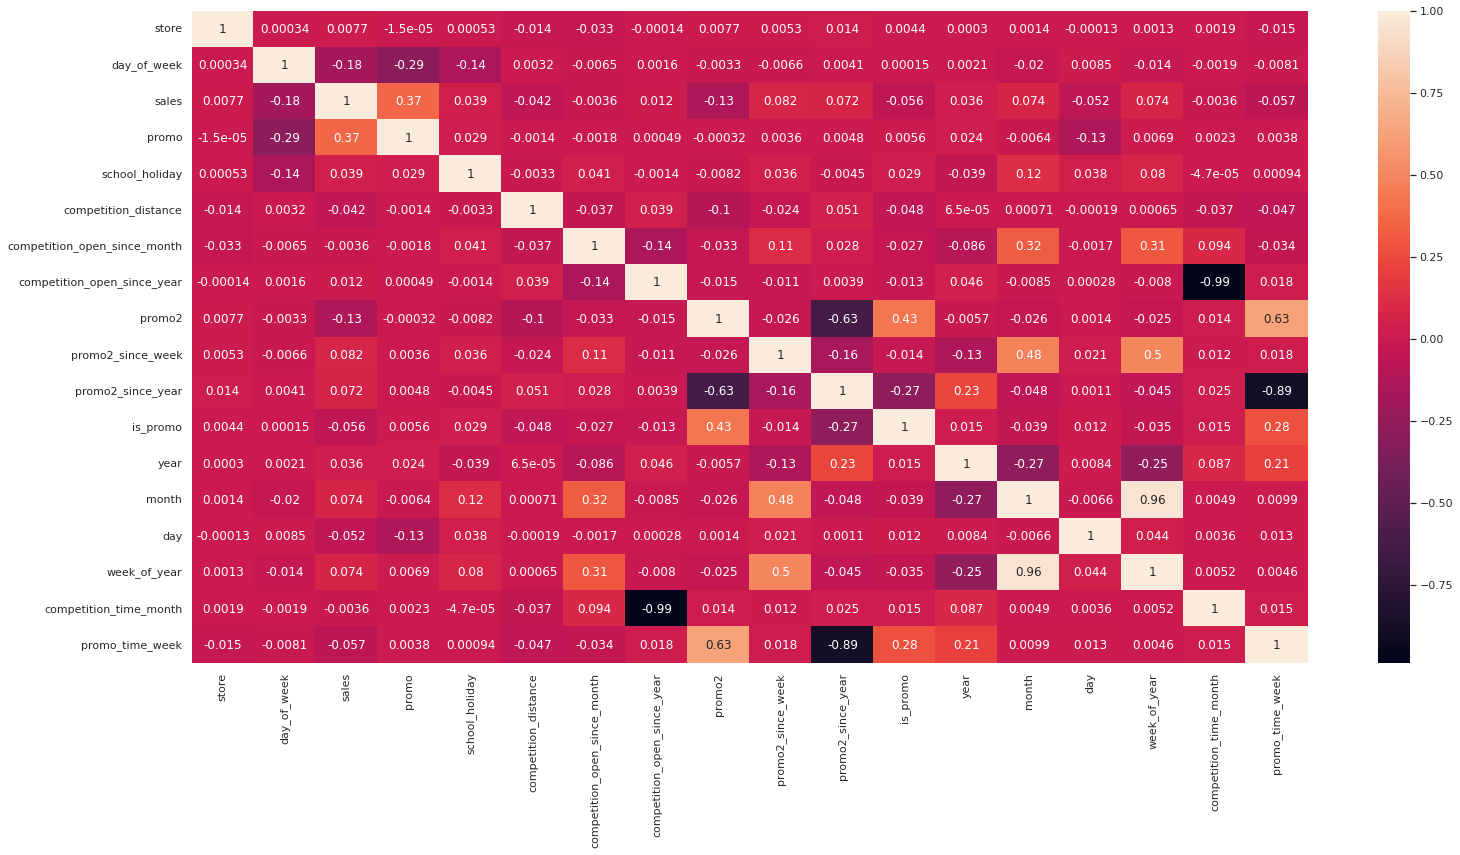

In [57]:
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

### 4.3 Analise Multivariada - Categorical Attributes

In [58]:
# filtrando apenas as colunas de caractere
a = df4.select_dtypes(include = 'object')

In [59]:
a.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


#### Correçaçao entre variavel categorica precisa-se utilizar o cramer v

In [60]:
cm = pd.crosstab(a['state_holiday'], a['store_type']).to_numpy()
chi2 = ss.chi2_contingency(cm) [0]

n = cm.sum()

r, k = cm.shape
v = np.sqrt ((chi2/n)/ min((k-1,r-1)))
# (a['state_holiday'] == 'christmas') & (a['store_type'] == 'a')
v

0.07106457093267678

In [61]:
# Calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# 5.0  Data Preparation

In [62]:
df5 = df4.copy()
df5.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 5.1 - Normalizaçao

## 5.2 - Rescaling

In [63]:
a = df5.select_dtypes(include = ['int64', 'float64'])

In [64]:
a.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,31,84,0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,31,94,279
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,31,105,226
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,31,71,0
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31,31,4,0


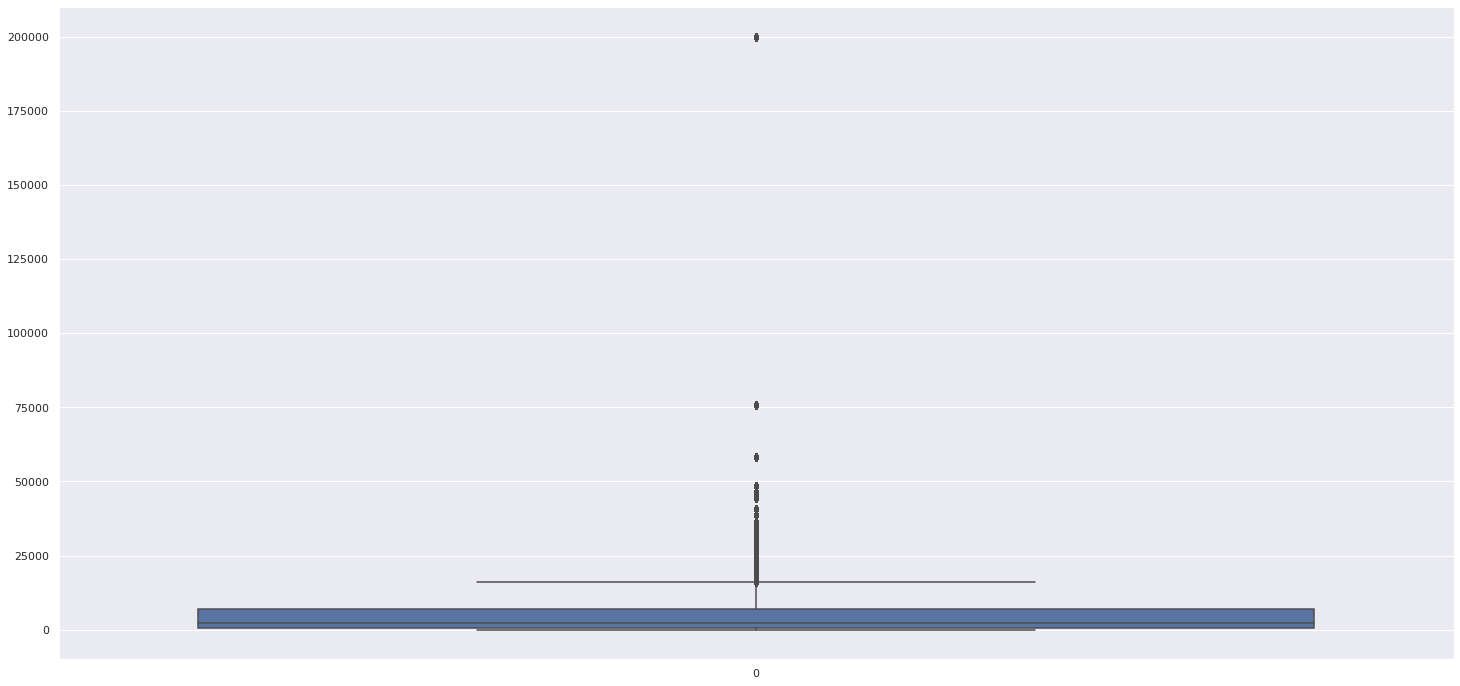

In [65]:
sns.boxplot(df5['competition_distance']);

In [66]:
# escolhendo as variaveis

# natureza ciclica:
# month
# day
# week of year
# day of week

In [67]:
rs = RobustScaler()
mms = MinMaxScaler()
# competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

pickle.dump(rs, open('/home/geo/COMUNIDADE_DS/DS_EM_PRODUCAO/webapp/parameter/competition_distance_scaler.pkl','wb'))

# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

pickle.dump(rs, open('/home/geo/COMUNIDADE_DS/DS_EM_PRODUCAO/webapp/parameter/competition_time_month_scaler.pkl','wb'))

#promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

pickle.dump(rs, open('/home/geo/COMUNIDADE_DS/DS_EM_PRODUCAO/webapp/parameter/promo_time_week_scaler.pkl','wb'))

# year
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump(mms, open('/home/geo/COMUNIDADE_DS/DS_EM_PRODUCAO/webapp/parameter/year_scaler.pkl','wb'))

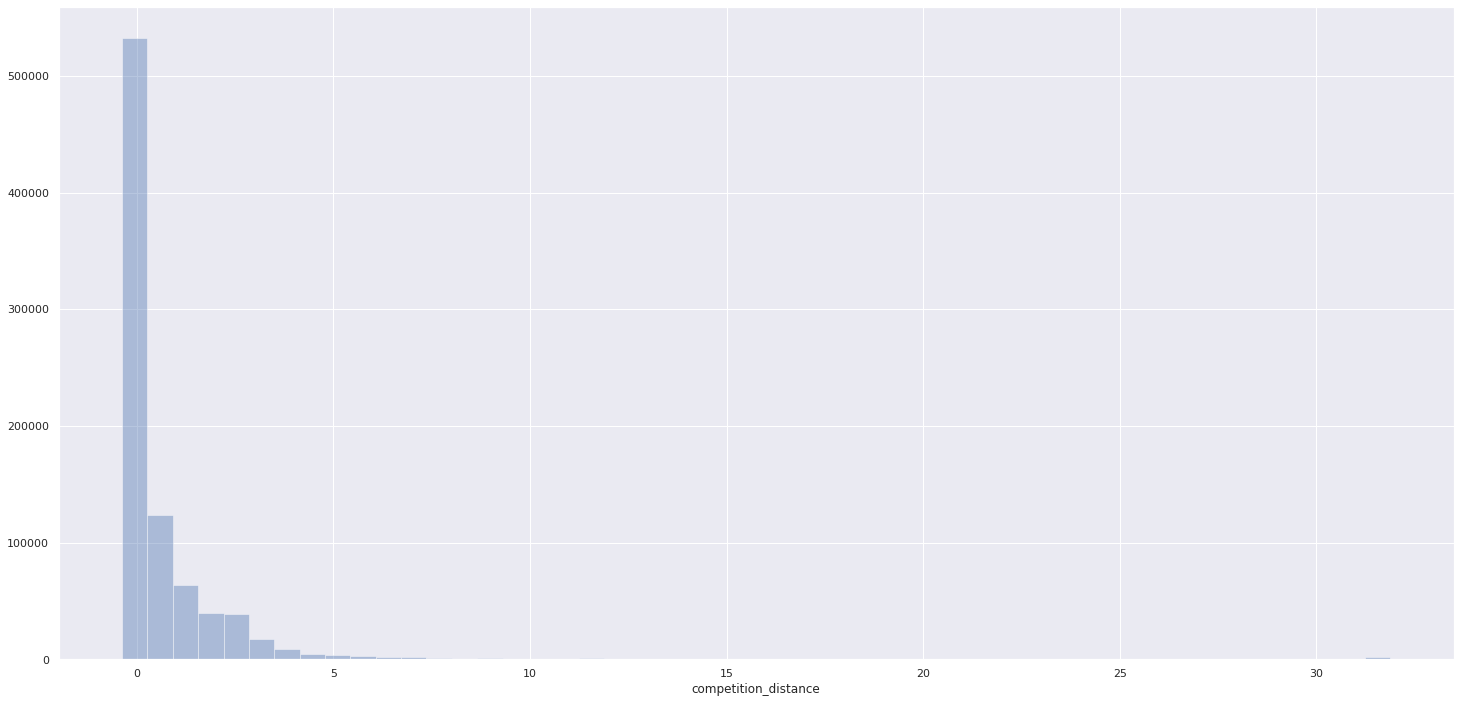

In [68]:
sns.distplot(df5['competition_distance'], kde = False)

## 5.3 - Transformacao

### 5.3.1 Encoding

In [69]:
df5 ['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

In [70]:
df5.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016


In [71]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix = ['state_holiday'], columns = ['state_holiday'])

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le, open('/home/geo/COMUNIDADE_DS/DS_EM_PRODUCAO/webapp/parameter/store_type_scaler.pkl','wb'))

# assortment - Ordinal Encoding
assortment_dict = {'basic':1, 
                   'extra': 2,
                   'extended': 3}
df5 ['assortment'] = df5 ['assortment'].map(assortment_dict)



### 5.3.2 Response Variabel Transformation

In [72]:
df5['sales'] = np.log1p(df5['sales']) # transformaçao de variavel resposta com logaritimico

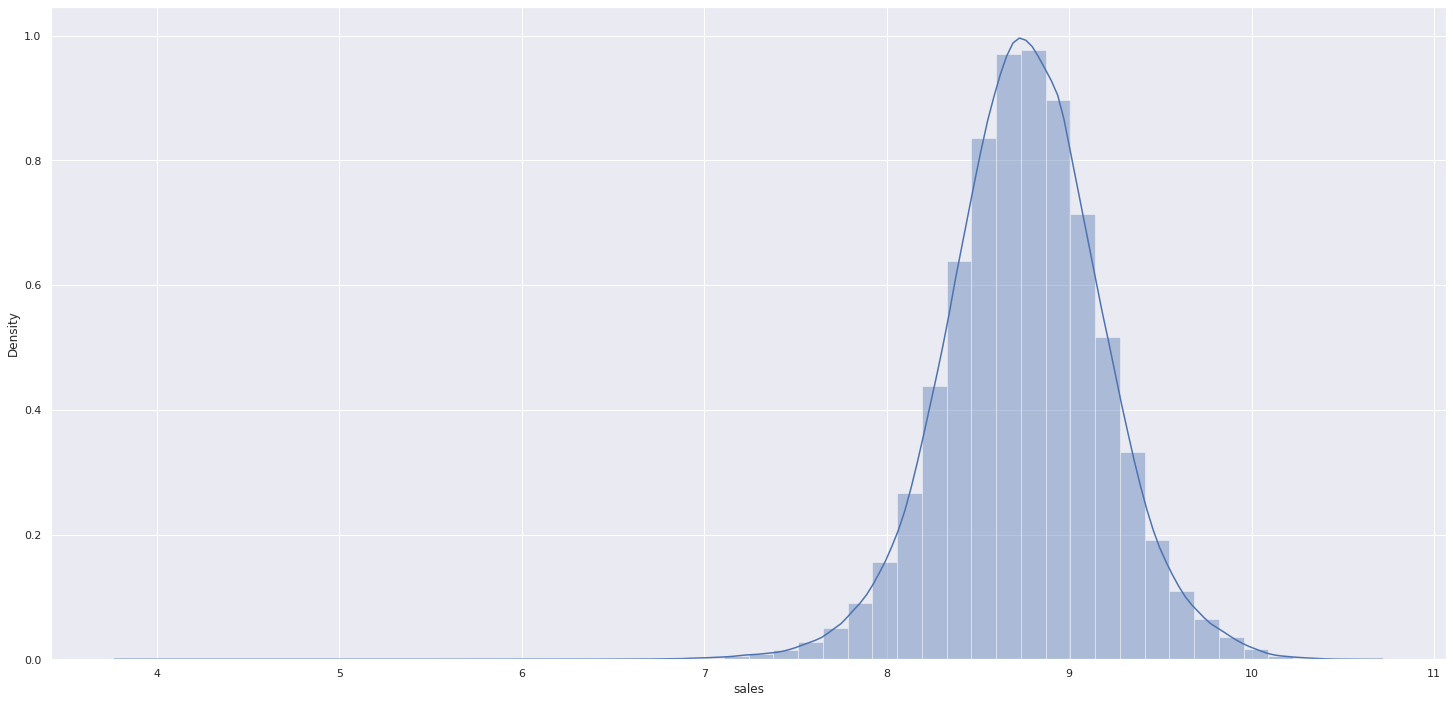

In [73]:
sns.distplot(df5['sales']);

### 5.3.3 Nature Transformation

In [74]:
# day_of_week
df5['day_of_week_sen'] = df5['day_of_week'].apply(lambda x: np.sin (x * (2.* np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos (x * (2.* np.pi/7)))

# day
df5['day_sen'] = df5['day'].apply(lambda x: np.sin (x * (2.* np.pi/31)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos (x * (2.* np.pi/31)))

# month
df5['month_sen'] = df5['month'].apply(lambda x: np.sin (x * (2.* np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos (x * (2.* np.pi/12)))

# week_of_year
df5['week_of_year_sen'] = df5['week_of_year'].apply(lambda x: np.sin (x * (2.* np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos (x * (2.* np.pi/52)))


In [75]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sen,day_of_week_cos,day_sen,day_cos,month_sen,month_cos,week_of_year_sen,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-2.449294e-16,1.0,-0.5,-0.866025,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.974928,-0.222521,-2.449294e-16,1.0,-0.5,-0.866025,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.974928,-0.222521,-2.449294e-16,1.0,-0.5,-0.866025,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-2.449294e-16,1.0,-0.5,-0.866025,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-2.449294e-16,1.0,-0.5,-0.866025,-0.568065,-0.822984


# 6.0 Boruta - feature selection

In [76]:
df6 = df5.copy()

In [77]:
df6.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sen,day_of_week_cos,day_sen,day_cos,month_sen,month_cos,week_of_year_sen,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-2.449294e-16,1.0,-0.5,-0.866025,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.974928,-0.222521,-2.449294e-16,1.0,-0.5,-0.866025,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.974928,-0.222521,-2.449294e-16,1.0,-0.5,-0.866025,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-2.449294e-16,1.0,-0.5,-0.866025,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-2.449294e-16,1.0,-0.5,-0.866025,-0.568065,-0.822984


In [78]:
# deletando variaveis que foram derivadas

cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)

## 6.1 Boruta - split dataframe into training and test dataset


O treino e teste serve para: uma parte do conjunto de dados é treinada  e com esses dados os modelos sao treinados e esses modelos sao usados sobre o conjunto de teste para verifificar a acuracia
no caso as ultimas 6 semanas de vendas serao o teste e desde o primeiro dia de venda ate antes dessas ultimas 6 semanas serao o treino

In [79]:
# pegando a primeira data a partir das ultimas 6 semanas
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days= 7*6 )

Timestamp('2015-06-19 00:00:00')

In [80]:
# treinando o dataset
# o y pega dentro do dataset do x
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']


# testando o dataset

X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Training Min Date: {}'. format(X_train['date']. min()))
print('Training Max Date: {}'. format(X_train['date']. max()))

print('\nTest Min Date: {}'. format(X_test['date']. min()))
print('Test MAx Date: {}'. format(X_test['date']. max()))


Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test MAx Date: 2015-07-31 00:00:00


## 6.2 Boruta as feature selector

In [76]:
# implementando como feature selection
# argumentos é o modelo que vai utilizar para a selecao de feature (rf) e o random state a partir de 42 e nao pode selecionar um dataframe e sim um vetor de numeros, para criar é só colocar _n
# trinando e testando o dataset para o boruta
#X_train_n = X_train.drop(['date','sales'], axis=1).values
# ravel é para colocar em vetor
#y_train_n = y_train.values.ravel()
# definindo randomforestregressor
#rf = RandomForestRegressor(n_jobs=-1) # utilizar todos os cores do note e criar o processamento em paralelo
# definindo o boruta
#boruta = BorutaPy( rf, n_estimators = 'auto', verbose = 2, random_state= 42).fit(X_train_n, y_train_n) 

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


### 6.2.1. Best Features from Boruta

In [77]:
## utilizar as variaveis que o boruta selecionou como mais relevantes (melhores features do boruta)
#cols_selected = boruta.support_.tolist() # support fornece o valor da rank que ele ranqueou baseado na relevancia conforme a coluna e sua imoprtancia

#X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )

## transformando em df e em seguida uma lista desse df as cols selecionadas
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

## transformando em uma lista as cols nao selecionadas por nao serem relevantes
#cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )


In [81]:
"""depois de saber as colunas, é necessario verificar com o test de hipotese no modulo 4 o que tem em comum. O aconcelhavel é pegar e comparar com as relevancias( as altas mesmo sendo falsas) e se é verdadeira, por exemplo da 8 a 12.
mas la diz que o ano é relevante e na analise do boruta nao é, o recomendavel é se tiver duvida de utilizar ou nao a variavel, utiliza no primeiro ciclo do crisp as sugestoes do boruta, 
depois pode adicionar e ver se a acuracia aumenta

como exemplo, nesse primeiro ciclo, o ano sera deixado de fora

verificando se as hipoteses fazem sentido e estao dentro do boruta, faz o marge e segue o modelo

nao siga cegamente o algoritimo, siga seu feeling tambem
"""

'depois de saber as colunas, é necessario verificar com o test de hipotese no modulo 4 o que tem em comum. O aconcelhavel é pegar e comparar com as relevancias( as altas mesmo sendo falsas) e se é verdadeira, por exemplo da 8 a 12.\nmas la diz que o ano é relevante e na analise do boruta nao é, o recomendavel é se tiver duvida de utilizar ou nao a variavel, utiliza no primeiro ciclo do crisp as sugestoes do boruta, \ndepois pode adicionar e ver se a acuracia aumenta\n\ncomo exemplo, nesse primeiro ciclo, o ano sera deixado de fora\n\nverificando se as hipoteses fazem sentido e estao dentro do boruta, faz o marge e segue o modelo\n\nnao siga cegamente o algoritimo, siga seu feeling tambem\n'

In [79]:
#cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sen',
 'day_of_week_cos',
 'day_sen',
 'day_cos',
 'month_cos',
 'week_of_year_cos']

In [80]:
#cols_not_selected_boruta

['is_promo',
 'month_sen',
 'school_holiday',
 'state_holiday_christmas',
 'state_holiday_easter_holiday',
 'state_holiday_public_holiday',
 'state_holiday_regular_day',
 'week_of_year_sen',
 'year']

In [82]:
tab = [['Hipoteses','Comclusão', 'Relevancia'],
['H1', 'FALSA', 'BAIXA'],
['H2', 'FALSA', 'MEDIA'],
['H3', 'FALSA', 'MEDIA'],
['H4', 'FALSA', 'BAIXA'],
['H5', '--', '--'],
['H7', 'FALSA', 'BAIXA'],
['H7', 'FALSA', 'MEDIA'],
['H8', 'FALSA', 'ALTA'],
['H9', 'FALSA', 'ALTA'],
['H10', 'VERDADEIRA', 'ALTA'],
['H11', 'VERDADEIRA', 'ALTA'],
['H12', 'VERDADEIRA', 'BAIXA']]

print(tabulate(tab,headers = 'firstrow'))

Hipoteses    Comclusão    Relevancia
-----------  -----------  ------------
H1           FALSA        BAIXA
H2           FALSA        MEDIA
H3           FALSA        MEDIA
H4           FALSA        BAIXA
H5           --           --
H7           FALSA        BAIXA
H7           FALSA        MEDIA
H8           FALSA        ALTA
H9           FALSA        ALTA
H10          VERDADEIRA   ALTA
H11          VERDADEIRA   ALTA
H12          VERDADEIRA   BAIXA


## 6.3 Selecionando as features manualmente

In [83]:
cols_selected_boruta = [
'store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sen',
 'day_of_week_cos',
 'month_sen',
 'month_cos',
 'day_sen',
 'day_cos',
 'week_of_year_sen',
 'week_of_year_cos']

# adicionando o date e sales porque o date utiliza para separar os modelos e o sales é a variavel resposta
feat_to_add = ['date', 'sales']


# features finais
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 7.0 Machine Learning Modelling

In [84]:
# pegar as features selecionadas do boruta

x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]


# Time Series Data Preparation
x_training = X_train[ cols_selected_boruta_full ]

In [85]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sen',
 'day_of_week_cos',
 'month_sen',
 'month_cos',
 'day_sen',
 'day_cos',
 'week_of_year_sen',
 'week_of_year_cos']

## 7.1 - Average Model

In [86]:
#criando um df auxiliar para fazer a media de vendas de cada uma das lojas colocando a coluna sales do y_test e por funm fazendo agrupamento das lojas com vendas, alem de renomear as colunas e por fim fazendo um merge.
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns = {'sales':'prediction'})
aux1 = pd.merge(aux1,aux2, how = 'left', on='store')

# é na matematica tudo que é estimado do valor real, neste caso o modelo
yhat_baseline = aux1['prediction']


# performace (calculando a performace com o ml error, atencao, no modulo 5 foi aplicado o log para transformar a variavel responde, agora temos que voltar com a variavel sales como era a original, utilizando o exponencial)
#ml_error('nome do modelo', np.expm1(vendas reais), np.expm1(predicoes))

baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result


,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2 - Linear Regression Model

In [87]:
# Model
lr = LinearRegression().fit(x_train,y_train) # vai treinar o modelo

# Prediction
yhat_lr = lr.predict(x_test)

# Performace
lr_result = ml_error('Linear regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear regression,1867.654504,0.292836,2671.333847


### 7.2.1. Linear Regression Model - Cross Validation


In [89]:
#lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=False )
#lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.31 +/- 295.69,0.3 +/- 0.02,2951.88 +/- 468.22


## 7.3 - Linear Regression Regularized Model - Lasso

In [88]:
# Model
lrr = Lasso(alpha = 0.01).fit(x_train,y_train) # vai treinar o modelo

# Prediction
yhat_lrr = lr.predict(x_test)

# Performace
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1867.654504,0.292836,2671.333847


### 7.3.1.  Lasso - Cross Validation


In [91]:
#lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose=False )
#lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2115.78 +/- 341.38,0.29 +/- 0.01,3056.85 +/- 503.74


## 7.4 - Randon Forest Regressor - Nao linear

In [89]:
# Model
#rf = RandomForestRegressor(n_estimators = QUANTAS ARVORES IRA CRIAR (2500 em media), n_jobs = RODAR EM PARALELO OS CORES DO NOTE, random_state = ORIGEM DOS NUMEROS ALEATORIOS)
rf = RandomForestRegressor(n_estimators = 100, n_jobs = -1, random_state = 42). fit(x_train,y_train)

# Prediction
yhat_rf = rf.predict(x_test)

# Performace
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,676.328179,0.099661,1005.127206


### 7.4.1.  Random Forest Regressor - Cross Validation

In [93]:
#rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=True )
#rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,861.57 +/- 251.59,0.12 +/- 0.03,1300.16 +/- 388.43


## 7.5 XGBoost Regressor

In [90]:
# Model
#model_xgb = xgb.XGBRegressor(objective = 'funcao objetiva', 
#                             n_estimators = QUANTAS ARVORES IRA CRIAR(2500 em media), 
#                             eta = quantaspassadas usa para fazer o aprendizado, 
#                             max_depth = maxima ramificacao que a arvore pode chegar,
#                             subsample = quantas amostras ou % de todas as porcentagem que quero fazer a amostragem
#                             colsample_bytee = sample por cada uma das arvores)

# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=100, 
                              eta=0.01, 
                              max_depth=10, 
                              subsample=0.7,
                              colsample_bytree=0.9 ).fit( x_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,865.289251,0.125609,1273.460241


### 7.5.1. XGBoost Regressor - Cross Validation


In [96]:
#xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
#xgb_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1080.4 +/- 189.09,0.15 +/- 0.02,1560.7 +/- 273.31


## 7.6 Compare model's performace

### 7.6.1. Single Performance

In [91]:
modelling_result = pd.concat([baseline_result,lr_result,lrr_result, rf_result,xgb_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,676.328179,0.099661,1005.127206
0,XGBoost Regressor,865.289251,0.125609,1273.460241
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear regression,1867.654504,0.292836,2671.333847
0,Linear Regression - Lasso,1867.654504,0.292836,2671.333847


O Fenomeno que estamos vendo da Rosmann náo é um problema simples e sim complexo e a random forest e xgboost funcionaram bem, sendo o mais adequado para utilizar -
Cuidado na hora de analisar a semana com dados mais comportados, por isso é necessario avaliar os modelos de machine learning somente pela ultima semana de vendas, por exemplo... Por isso é necessario o cross validation, cortando varias fatias do conjunto de dados para testes para que tenha varias medicoes da performace desse modelo, fazendo uma media de tudo tornando uma performace real do modelo.

### 7.6.2. Real Performance - Cross Validation


In [98]:
#modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
#modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.31 +/- 295.69,0.3 +/- 0.02,2951.88 +/- 468.22
0,Lasso,2115.78 +/- 341.38,0.29 +/- 0.01,3056.85 +/- 503.74
0,Random Forest Regressor,861.57 +/- 251.59,0.12 +/- 0.03,1300.16 +/- 388.43
0,XGBoost Regressor,1080.4 +/- 189.09,0.15 +/- 0.02,1560.7 +/- 273.31


quando se é feito o cross validation, conseguimos verificar quem tem uma performace menor e melhor em relacao aos demais feitos

# 8.0 - Hyperparameter Fine Tunning

## 8.1 Random Search

In [92]:
## dicionario com valores de parametros, no random search é recomendado criar lista de valores espaçados
param = {
    'n_estimators': [1500, 1700, 2500, 3000, 3500],
    'eta': [0.01, 0.03],
    'max_depth': [3, 5, 9],
    'subsample': [0.1, 0.5, 0.7],
    'colsample_bytree': [0.3, 0.7, 0.9],
    'min_child_weight': [3, 8, 15]
        }

MAX_EVAL = 5

In [93]:
import random

In [ ]:
# sorteio de quantas iteracoes terei

final_result = pd.DataFrame()

for i in range( MAX_EVAL ):
    # choose values for parameters randomly
    #hp = { chave: random(classe).sample(metodo)( valor, um valor so)[valor dele] for chave, valor in param.items(retorna os itens dentro do dic)}
    # ou seja, vai criar um dicionario, escolhendo a chave e valor separadamente em uma iteracao
    hp = { k: random.sample(v,1)[0] for k, v in param.items() }
    print( hp )
    
    # model
    model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                                  n_estimators=hp['n_estimators'], 
                                  eta=hp['eta'], 
                                  max_depth=hp['max_depth'], 
                                  subsample=hp['subsample'],
                                  colsample_bytee=hp['colsample_bytree'],
                                  min_child_weight=hp['min_child_weight'] )

    # performance
    result = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
    final_result = pd.concat( [final_result, result] )

{'n_estimators': 1700, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 8}

KFold Number: 5

KFold Number: 4

KFold Number: 3


In [ ]:
final_result

## 8.2 Final Model

In [87]:
# colocando os parametros que o passo anterior escolheu como melhores
param_tuned = {
    'n_estimators': 3000,
    'eta': 0.03,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3 
        }

In [88]:
# model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'], 
                                    eta=param_tuned['eta'], 
                                    max_depth=param_tuned['max_depth'], 
                                    subsample=param_tuned['subsample'],
                                    colsample_bytee=param_tuned['colsample_bytree'],
                                    min_child_weight=param_tuned['min_child_weight'] ).fit( x_train, y_train )

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,639.303084,0.094812,923.894815


In [89]:
mpe = mean_percentage_error (np.expm1(y_test), np.expm1(yhat_xgb_tuned))
mpe

-0.00800501389514577

# 9.0 - Traducao e interpretacao do Erro

In [91]:
df9 = X_test[cols_selected_boruta_full]

In [92]:
df9 = X_test[cols_selected_boruta_full]

# rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

## 9.1 - Business Performace

In [93]:
# somar as predicoes para saber o retorno financeiro do modelo
df91 = df9[['store','predictions']].groupby('store').sum().reset_index()

# MAE E MAPE

df9_aux1 = df9[['store','sales','predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'],x['predictions'])).reset_index().rename(columns={0:'MAE'})
df9_aux2 = df9[['store','sales','predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'],x['predictions'])).reset_index().rename(columns={0:'MAPE'})

#MERGE
df9_aux3 = pd.merge(df9_aux1,df9_aux2, how = 'inner', on = 'store')
df92 = pd.merge(df91,df9_aux3, how = 'inner', on = 'store')

# cenarios
df92 ['worst_scenario'] = df92['predictions']-df92['MAE']
df92 ['best_scenario'] = df92['predictions']+df92['MAE']


# order columns 
df92 = df92[['store','predictions','worst_scenario','best_scenario','MAE','MAPE']]

In [94]:
df92.sample(4)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
1008,1009,180452.343750,180073.824074,180830.863426,378.519676,0.079877
991,992,203145.375000,202614.950426,203675.799574,530.424574,0.118491
763,764,141629.578125,141313.541398,141945.614852,316.036727,0.077067
158,159,283912.125000,283413.404600,284410.845400,498.720400,0.063112


In [95]:
df92.sort_values('MAPE', ascending= False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,105759.242188,102494.061305,109024.423070,3265.180883,0.559597
908,909,244256.781250,236776.993674,251736.568826,7479.787576,0.511927
875,876,210280.296875,206328.857072,214231.736678,3951.439803,0.319502
594,595,372453.875000,368217.142050,376690.607950,4236.732950,0.298223
721,722,352444.875000,350467.878180,354421.871820,1976.996820,0.266096


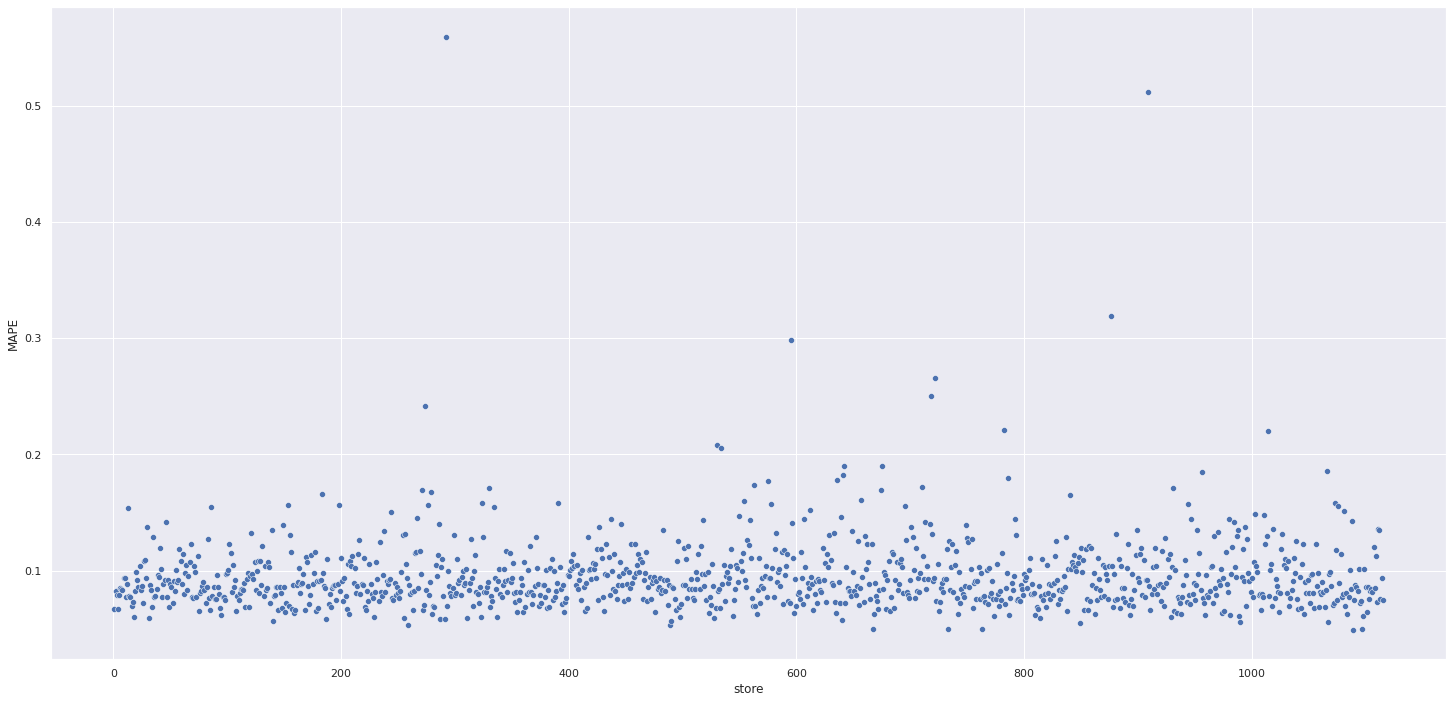

In [96]:
sns.scatterplot(x='store',y='MAPE', data = df92);

## 9.2 - Total Performace

In [97]:
df93 = df92[['predictions','worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis = 0 ).reset_index().rename(columns={'index':'scenario', 0:'values'})
df93['values'] = df93['values'].map('R${:,.2f}'.format)
df93

,scenario,values
0,predictions,"R$287,070,341.82"
1,worst_scenario,"R$286,353,756.82"
2,best_scenario,"R$287,786,926.82"


## 9.3 - Machine Learning Performace

In [98]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales'] 

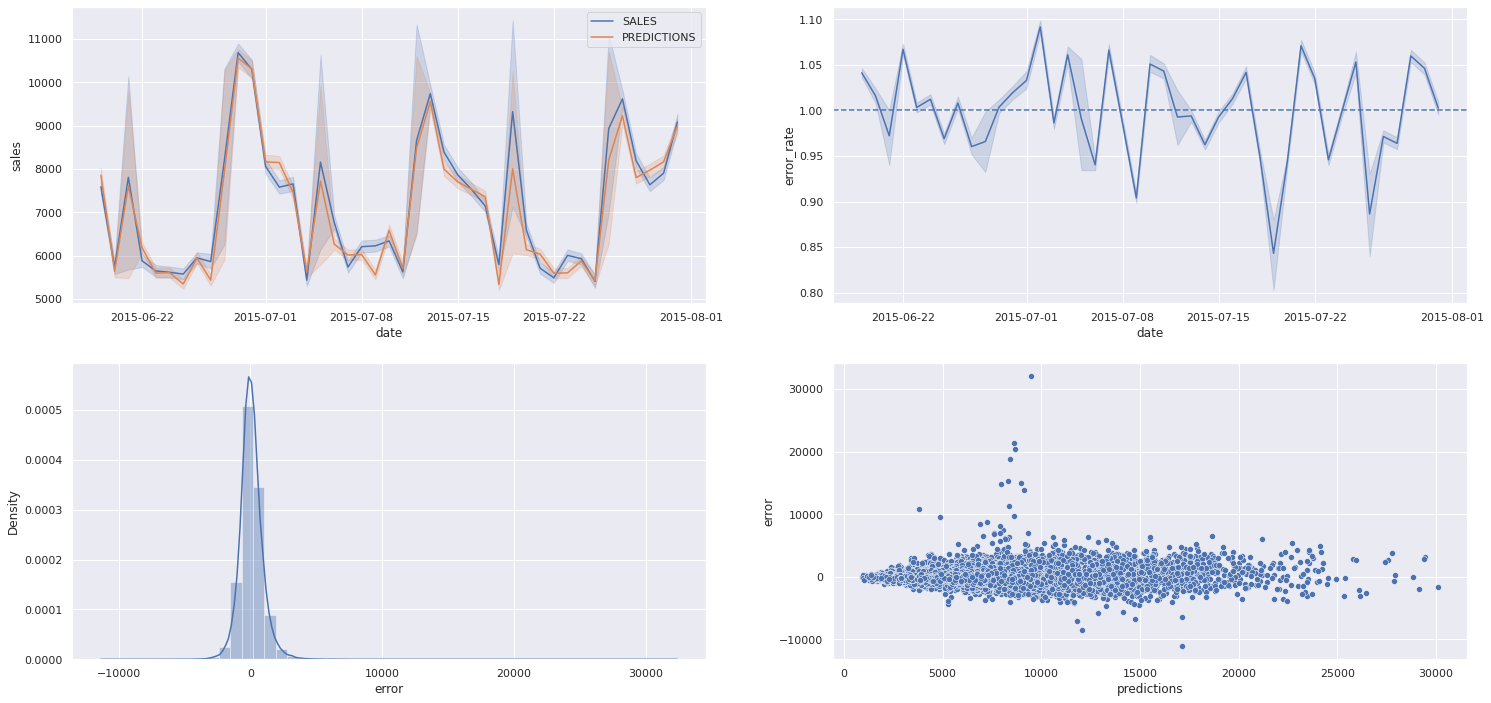

In [103]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9 )
plt.axhline( 1, linestyle='--')

plt.subplot( 2, 2, 3 )
sns.distplot( df9['error'] )

plt.subplot( 2, 2, 4 )
sns.scatterplot( x=df9['predictions'], y=df9['error'] )

In [ ]:
#import  pickle

In [ ]:
# with open('model_rossmann.pkl', 'wb') as to_write:
#    pickle.dump(model_xgb_tuned, to_write)
#
#with open('model_rossmann.pkl','rb') as read_file:
#    df = pickle.load(read_file)

# 10.0 - Deploy Model to Production

In [104]:
import pickle

In [105]:
pickle.dump( model_xgb_tuned, open('/home/geo/COMUNIDADE_DS/DS_EM_PRODUCAO/webapp/model/model_rossmann.pkl', 'wb'))

## 10.1 - Rosmann Class

In [106]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann( object ):
    def __init__( self ):
        self.home_path='/home/geo/COMUNIDADE_DS/DS_EM_PRODUCAO/'
        self.competition_distance_scaler   = pickle.load( open( self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb') )
        self.competition_time_month_scaler = pickle.load( open( self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb') )
        self.promo_time_week_scaler        = pickle.load( open( self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb') )
        self.year_scaler                   = pickle.load( open( self.home_path + 'parameter/year_scaler.pkl', 'rb') )
        self.store_type_scaler             = pickle.load( open( self.home_path + 'parameter/store_type_scaler.pkl', 'rb') )
        
        
    def data_cleaning( self, df1 ): 
        
        ## 1.1. Rename Columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
                    'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore( x )

        cols_new = list( map( snakecase, cols_old ) )

        # rename
        df1.columns = cols_new

        ## 1.3. Data Types
        df1['date'] = pd.to_datetime( df1['date'] )

        ## 1.5. Fillout NA
        #competition_distance        
        df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

        #competition_open_since_month
        df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

        #competition_open_since_year 
        df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

        #promo2_since_week           
        df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

        #promo2_since_year           
        df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

        #promo_interval              
        month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

        df1['promo_interval'].fillna(0, inplace=True )

        df1['month_map'] = df1['date'].dt.month.map( month_map )

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

        ## 1.6. Change Data Types
        # competiton
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

        # promo2
        df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
        df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )
        
        return df1 


    def feature_engineering( self, df2 ):

        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear

        # year week
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

        # competition since
        df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
        df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
        df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

        # assortment
        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

        # 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS
        ## 3.1. Filtragem das Linhas
        df2 = df2[df2['open'] != 0]

        ## 3.2. Selecao das Colunas
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop( cols_drop, axis=1 )
        
        return df2


    def data_preparation( self, df5 ):

        ## 5.2. Rescaling 
        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform( df5[['competition_distance']].values )
    
        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform( df5[['competition_time_month']].values )

        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform( df5[['promo_time_week']].values )
        
        # year
        df5['year'] = self.year_scaler.fit_transform( df5[['year']].values )

        ### 5.3.1. Encoding
        # state_holiday - One Hot Encoding
        df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

        # store_type - Label Encoding
        df5['store_type'] = self.store_type_scaler.fit_transform( df5['store_type'] )

        # assortment - Ordinal Encoding
        assortment_dict = {'basic': 1,  'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map( assortment_dict )

        
        ### 5.3.3. Nature Transformation
        # day of week
        df5['day_of_week_sen'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

        # month
        df5['month_sen'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

        # day 
        df5['day_sen'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
        df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

        # week of year
        df5['week_of_year_sen'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )
        
        
        cols_selected = [ 'store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month',
            'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week',
            'day_of_week_sen', 'day_of_week_cos', 'month_sen', 'month_cos', 'day_sen', 'day_cos', 'week_of_year_sen', 'week_of_year_cos']
      
        
        return df5[ cols_selected ]
    
    
    def get_prediction( self, model, original_data, test_data ):
        # prediction
        pred = model.predict( test_data )
        
        # join pred into the original data
        original_data['prediction'] = np.expm1( pred )
        
        return original_data.to_json( orient='records', date_format='iso' )

## 10.2 - API Handler

In [109]:
import os
import pickle
import pandas as pd
from flask             import Flask, request, Response
from rossmann.Rossmann import Rossmann

# loading model
model = pickle.load( open( '/home/geo/COMUNIDADE_DS/DS_EM_PRODUCAO/webapp/model/model_rossmann.pkl', 'rb') )

# initialize API
app = Flask( __name__ )

@app.route( '/rossmann/predict', methods=['POST'] )
def rossmann_predict():
    test_json = request.get_json()
   
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
            
        # Instantiate Rossmann class
        pipeline = Rossmann()
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
        
        
    else:
        return Reponse( '{}', status=200, mimetype='application/json' )

if __name__ == '__main__':
    port = os.environ.get('PORT', 5000)
    app.run( '0.0.0.0' )

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://192.168.1.103:5000
Press CTRL+C to quit


## 10.1 - API Tester

In [110]:
import requests

In [111]:
# loading test dataset
df10 = pd.read_csv( '/home/geo/COMUNIDADE_DS/DS_EM_PRODUCAO/Data/test.csv' )

In [112]:
# merge test dataset + store
df_test = pd.merge( df10, df_store_raw, how='left', on='Store' )

# choose store for prediction
df_test = df_test[df_test['Store'].isin( [20, 23, 22] )]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop( 'Id', axis=1 )

In [113]:
# convert Dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [114]:
# API Call
#url = 'http://0.0.0.0:5000/rossmann/predict'
url = 'https://rossmannpredictonlinee.onrender.com/rossmann/predict'
header = {'Content-type': 'application/json' } 
data = data

r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

Status Code 200


In [115]:
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())

In [116]:
d2 = d1[['store', 'prediction']].groupby( 'store' ).sum().reset_index()

for i in range( len( d2 ) ):
    print( 'Store Number {} will sell R${:,.2f} in the next 6 weeks'.format( 
            d2.loc[i, 'store'], 
            d2.loc[i, 'prediction'] ) )

Store Number 20 will sell R$336,467.14 in the next 6 weeks
Store Number 22 will sell R$228,862.26 in the next 6 weeks
Store Number 23 will sell R$243,223.71 in the next 6 weeks
